## ⚠️ Important Note

This is a copy of the competition winner's work, all credit for the code and ideas should go to them.

I will be changing things up and making notes on this version of the notebook, to view the original please visit the author's repo [here](https://github.com/bakarys01/hydropower-kalam-winner).

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import time
import logging
import os
import gc
import json
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, train_test_split
from bayes_opt import BayesianOptimization
import random
import warnings
warnings.filterwarnings('ignore')

def seed_everything(seed: int = 42):
    """
    Set random seed for reproducibility in Python and NumPy.
    
    Args:
        seed (int): The seed value (default: 42)
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything()

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Create output folder
os.makedirs('output', exist_ok=True)

# IBM SkillsBuild Hydropower Climate Optimization Challenge First Place Solution

## Overview and Objectives

This solution tackles the IBM SkillsBuild Hydropower Climate Optimization Challenge, which focuses on predicting daily energy consumption for different consumer devices in Kalam, Pakistan. The solution leverages comprehensive feature engineering, temporal data segmentation, and advanced ensemble modeling to achieve accurate predictions despite the region's challenging seasonal patterns and extreme weather conditions.

**Objectives:**
- Predict daily energy consumption (kWh) for various consumer devices in Kalam
- Capture seasonal and weather-dependent energy usage patterns
- Handle offline periods and missing data appropriately
- Create a robust model that generalizes well across different devices and time periods

## Architecture Diagram

![Architecture Diagram](architecture.png)

## ETL Process

### Extract
- **Data Sources**: 
  - Primary dataset: Consumer energy consumption at 5-minute intervals
  - Climate data: Temperature, precipitation, wind components, and snowfall measurements
  - Sample submission file: Used to determine test set devices and prediction format
- **Data Formats**: CSV for electrical data, Excel for climate data
- **Considerations**: Device filtering to exclude devices and users not present in test set

### Transform
1. **Data Cleaning**:
   - Conversion of timestamps to datetime objects
   - Identification and exclusion of specific devices not in test set
   - Filtering to keep only users present in the test set

2. **Aggregation**:
   - Aggregation of 5-minute data to daily totals with multiple statistical metrics
   - Comprehensive metrics for voltage, current, and power factor (mean, std, min, max)

3. **Online/Offline Classification**:
   - Identification of entire weeks where consumption was zero across all days
   - Classification of days into "online" and "offline" based on weekly patterns
   - Focus on "online" days to improve signal quality

4. **Feature Engineering**:
   - Extraction of consumer device and user IDs from source strings
   - Creation of temporal features and cyclical encodings
   - Integration of climate data with multiple temperature metrics
   - Special features for Pakistan holidays and Ramadan periods
   - Advanced temperature trend features (acceleration, volatility, extremes)

### Load
- Intermediate data saved as CSV files for further processing:
- 
  - `offline_days_enriched.csv`: Days with zero power consumption (entire week)
  - `filtred_online_days_enriched.csv`: Final filtered dataset with only relevant users of Days with normal power consumption

## Data Modeling

### Strategic Data Segmentation
The data was strategically divided into four segments to capture different seasonal patterns:
1. **Data1**: August-September 2024 and October 2023 (late summer/early fall)
2. **Data2**: November-December 2023 and July 2024 (winter and mid-summer)
3. **Data3**: All other periods with distinct consumption patterns
4. **Data4**: Complete dataset for a global model

### Model Configurations
Seven different LightGBM configurations were trained for each data segment:
1. **Precise**: Conservative approach with deep trees (max_depth=8, learning_rate=0.01)
2. **Feature Selective**: Aggressive feature selection (colsample_bytree=0.6, feature_fraction=0.7)
3. **Robust**: Focus on outlier resistance (min_data_in_leaf=20, reg_alpha=0.5)
4. **Deep Forest**: Very deep trees with many estimators (max_depth=12, n_estimators=3000)
5. **Highly Regularized**: Strong regularization (reg_alpha=2.0, reg_lambda=2.0)
6. **Fast Learner**: High learning rate for quick convergence (learning_rate=0.08)
7. **Balanced**: Optimized for bias-variance tradeoff (max_depth=7, bagging_freq=5)

### Optimization Approach
- **Cross-Validation**: 5-fold cross-validation for robust model evaluation
- **Bayesian Optimization**: Used to find optimal weights for combining base models
- **Feature Importance Analysis**: Identified and leveraged the most predictive features
- **Performance Monitoring**: Tracked RMSE across both individual models and ensembles

# Data Loading and Initial Exploration

In this section, we load the main datasets and perform initial exploration:
1. Main consumption data (5-minute intervals)
2. Sample submission file to understand the prediction format
3. Climate data with meteorological measurements

We also apply initial filtering to focus only on devices present in the test set.

<div style="border: 2px solid orange; border-radius: 5px; padding: 0.8em; background-color: #FFF8E1; color: #333;">
  <strong>Note:</strong> The next cell may take approximately <em>3 to 5 minutes</em> to complete depending on the computer. 
  Please do not interrupt the kernel during execution.
</div>

In [4]:
###########################################
# LOADING DATA
###########################################
logger.info("Loading data...")
start_time = time.time()

# Loading main data
all_data_df = pd.read_csv("datasets/Data/Data.csv")
logger.info(f"✓ Main data loaded: {len(all_data_df):,} records")

# Display sample data
display(all_data_df.head())

# Extracting device ID for filtering
all_data_df['device_id'] = all_data_df['Source'].str.extract(r'consumer_device_(\d+)').astype(int)

# Filter devices to exclude (devices not present in test set)
DEVICES_TO_DROP = set([3, 5, 11, 14, 15, 17, 24, 25, 27, 33, 4, 9])
original_count = len(all_data_df)
all_data_df = all_data_df[~all_data_df['device_id'].isin(DEVICES_TO_DROP)]
logger.info(f"Device filtering: {original_count - len(all_data_df)} records removed")

# Remove device_id column which is no longer needed
all_data_df = all_data_df.drop(columns=['device_id'])

# Loading sample submission file
ss = pd.read_csv("datasets/SampleSubmission.csv")
logger.info(f"✓ Sample submission loaded: {len(ss):,} records")
display(ss.head())

# Loading climate data
climate_df = pd.read_excel('datasets/Climate Data/Climate Data/Kalam Climate Data.xlsx')
logger.info(f"✓ Climate data loaded: {len(climate_df):,} records")
display(climate_df.head())

# Basic preprocessing
all_data_df['date_time'] = pd.to_datetime(all_data_df['date_time'])
all_data_df['Date'] = pd.to_datetime(all_data_df['date_time'].dt.date)
all_data_df['Year'] = all_data_df['date_time'].dt.year

# Extracting device/user information
all_data_df[['consumer_device', 'data_user']] = all_data_df['Source'].str.extract(r'(consumer_device_\d+)_data_user_(\d+)')

elapsed = time.time() - start_time
logger.info(f"Data loading completed in {elapsed:.2f} seconds")

2025-04-22 11:41:40,133 - INFO - Loading data...
2025-04-22 11:42:27,683 - INFO - ✓ Main data loaded: 39,147,559 records


,date_time,v_red,current,power_factor,kwh,Source,v_blue,v_yellow,consumer_device_9,consumer_device_x
0,2024-07-22 18:20:00,137.65,0.08,0.72,0.000661,consumer_device_10_data_user_1,NaN,NaN,0,10
1,2024-07-22 18:25:00,122.82,0.08,0.73,0.000598,consumer_device_10_data_user_1,NaN,NaN,0,10
2,2024-07-22 18:30:00,119.70,0.08,0.74,0.000591,consumer_device_10_data_user_1,NaN,NaN,0,10
3,2024-07-22 18:35:00,124.53,0.08,0.75,0.000623,consumer_device_10_data_user_1,NaN,NaN,0,10
4,2024-07-22 18:40:00,134.84,0.08,0.74,0.000665,consumer_device_10_data_user_1,NaN,NaN,0,10


2025-04-22 11:43:23,747 - INFO - Device filtering: 15194237 records removed
2025-04-22 11:43:25,136 - INFO - ✓ Sample submission loaded: 6,014 records


,ID,kwh
0,2024-09-24_consumer_device_12_data_user_1,0
1,2024-09-25_consumer_device_12_data_user_1,0
2,2024-09-26_consumer_device_12_data_user_1,0
3,2024-09-27_consumer_device_12_data_user_1,0
4,2024-09-28_consumer_device_12_data_user_1,0


2025-04-22 11:43:27,011 - INFO - ✓ Climate data loaded: 12,228 records


,Date Time,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),V Wind Component (m/s),Total Precipitation (mm),Snowfall (mm),Snow Cover (%)
0,2023-06-03 13:00:00,7.199731,-2.448126,-0.034195,0.060989,0.000377,0.0,99.972656
1,2023-06-03 14:00:00,6.000620,-2.597540,-0.080688,0.018585,0.000398,0.0,99.972656
2,2023-06-03 15:00:00,4.789972,-2.696951,0.057449,-0.352020,0.000418,0.0,99.972656
3,2023-06-03 16:00:00,3.158746,-2.879324,0.051529,-0.608948,0.000420,0.0,99.972656
4,2023-06-03 17:00:00,1.671426,-3.255606,0.056137,-0.739838,0.000420,0.0,99.972656


2025-04-22 11:44:19,722 - INFO - Data loading completed in 159.59 seconds


# Data Preprocessing and Aggregation

In this section, we:
1. Aggregate the 5-minute data to daily totals
2. Calculate statistical metrics for each electrical parameter
3. Identify and separate online/offline periods
4. Filter to include only users present in the test set

In [5]:
###########################################
# ENRICHED DATA AGGREGATION (5min → DAILY)
###########################################
start_time = time.time()
logger.info("Enriched data aggregation (multiple metrics)...")

# Defining aggregations for electrical columns
daily_aggs = {
    'kwh': 'sum',
    'v_red': ['mean', 'std', 'min', 'max'],
    'v_blue': ['mean', 'std', 'min', 'max'],
    'v_yellow': ['mean', 'std', 'min', 'max'],
    'current': ['mean', 'std', 'min', 'max'],
    'power_factor': ['mean', 'min', 'max']
}

# Aggregation with multiple metrics
daily_data = all_data_df.groupby(['Source', 'Date']).agg(daily_aggs)
daily_data.columns = ['_'.join(col).strip() for col in daily_data.columns.values]
daily_data = daily_data.reset_index()
logger.info(f"Enriched aggregated data: {len(daily_data)} records")

# Display sample of aggregated data
display(daily_data.head())
elapsed = time.time() - start_time
logger.info(f"ENRICHED DATA AGGREGATION completed in {elapsed:.2f} seconds")

2025-04-22 11:46:18,347 - INFO - Enriched data aggregation (multiple metrics)...
2025-04-22 11:46:23,285 - INFO - Enriched aggregated data: 83492 records


,Source,Date,kwh_sum,v_red_mean,v_red_std,v_red_min,v_red_max,v_blue_mean,v_blue_std,v_blue_min,...,v_yellow_std,v_yellow_min,v_yellow_max,current_mean,current_std,current_min,current_max,power_factor_mean,power_factor_min,power_factor_max
0,consumer_device_10_data_user_1,2024-07-22,0.024330,99.162941,35.429561,0.0,138.29,NaN,NaN,NaN,...,NaN,NaN,NaN,0.079853,0.044804,0.0,0.13,0.384118,0.0,0.77
1,consumer_device_10_data_user_1,2024-07-23,0.103560,101.665556,59.016168,0.0,172.00,NaN,NaN,NaN,...,NaN,NaN,NaN,0.060486,0.050824,0.0,0.14,0.342986,0.0,0.80
2,consumer_device_10_data_user_1,2024-07-24,0.137543,100.080938,67.120827,0.0,179.31,NaN,NaN,NaN,...,NaN,NaN,NaN,0.074063,0.050556,0.0,0.16,0.399896,0.0,0.80
3,consumer_device_10_data_user_1,2024-07-25,0.121011,101.122604,59.350940,0.0,172.08,NaN,NaN,NaN,...,NaN,NaN,NaN,0.082743,0.048458,0.0,0.14,0.356250,0.0,0.94
4,consumer_device_10_data_user_1,2024-07-26,0.000000,32.168472,52.802693,0.0,145.20,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.00


2025-04-22 11:46:23,301 - INFO - ENRICHED DATA AGGREGATION completed in 4.95 seconds


# ONLINE/OFFLINE DATA SEPARATION

2025-04-22 11:52:11,474 - INFO - Separating data into online and offline days by week...
2025-04-22 11:52:20,836 - INFO - User filtering: 6769 records removed
2025-04-22 11:52:21,802 - INFO - Online days: 26,298, Offline days: 50,425


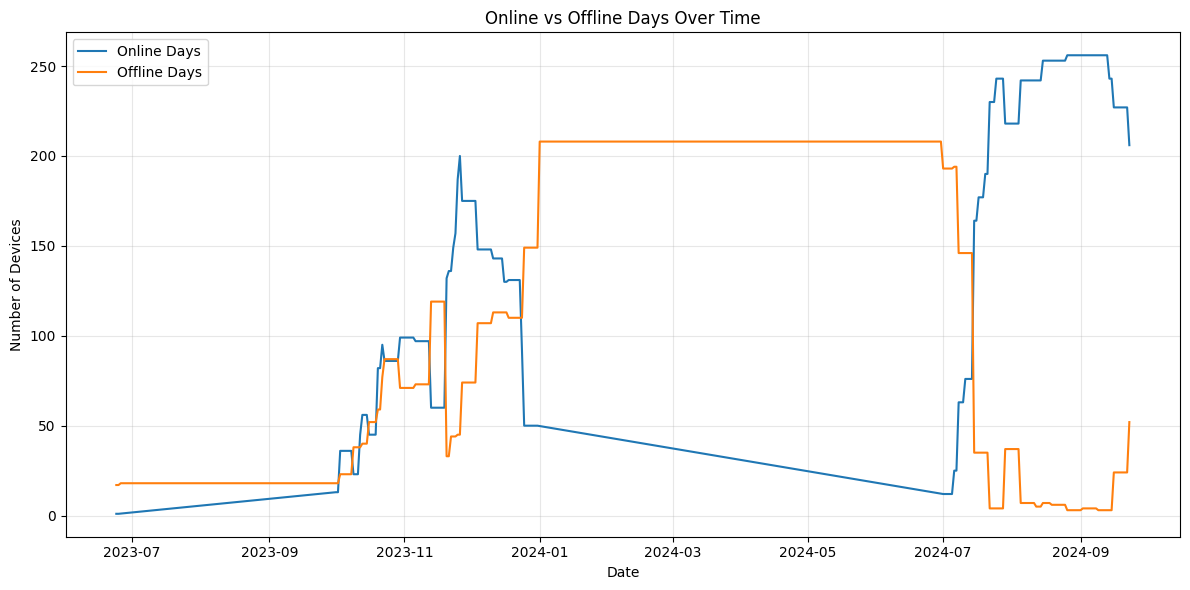

2025-04-22 11:52:22,099 - INFO - ONLINE/OFFLINE DATA SEPARATION completed in 10.62 seconds


In [6]:
###########################################
# ONLINE/OFFLINE DATA SEPARATION
###########################################
start_time = time.time()

logger.info("Separating data into online and offline days by week...")

# Add Year column and extract Date components
daily_data['Year'] = daily_data['Date'].dt.year
# Add column for week number
daily_data['Week'] = daily_data['Date'].dt.isocalendar().week
daily_data['Year_Week'] = daily_data['Year'].astype(str) + '_' + daily_data['Week'].astype(str)

# Identify sources that have zero consumption for an entire week
offline_weeks_by_source = []

# For each source and each week
for source, group in daily_data.groupby(['Source', 'Year_Week']):
    # If all days of the week have zero consumption
    if (group['kwh_sum'] == 0).all():
        offline_weeks_by_source.append(source)

# Mark days as offline if they belong to a source and week where all days have zero consumption
daily_data['is_offline'] = daily_data.apply(
    lambda row: (row['Source'], row['Year_Week']) in offline_weeks_by_source, 
    axis=1
)

# Separate into online and offline days
offline_data = daily_data[daily_data['is_offline']].copy()
online_data = daily_data[~daily_data['is_offline']].copy()

###########################################
# FILTERING FOR TEST USERS
###########################################
# Get list of users in test data
test_users = ss['ID'].str.extract(r'consumer_device_\d+_data_user_(\d+)')[0].astype(int).unique()

# Filter training data to only include users that are in test set
online_data['data_user'] = online_data['Source'].str.extract(r'consumer_device_\d+_data_user_(\d+)')[0].astype(int)
original_count = len(online_data)
online_data = online_data[online_data['data_user'].isin(test_users)]
logger.info(f"User filtering: {original_count - len(online_data)} records removed")

# Save online/offline data
online_data.to_csv('output/filtred_online_days_enriched.csv', index=False)
offline_data.to_csv('output/offline_days_enriched.csv', index=False)
logger.info(f"Online days: {len(online_data):,}, Offline days: {len(offline_data):,}")

# Visualize online vs offline patterns
plt.figure(figsize=(12, 6))
online_counts = online_data.groupby('Date').size()
offline_counts = offline_data.groupby('Date').size()

plt.plot(online_counts.index, online_counts, label='Online Days')
plt.plot(offline_counts.index, offline_counts, label='Offline Days')
plt.title('Online vs Offline Days Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Devices')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

elapsed = time.time() - start_time
logger.info(f"ONLINE/OFFLINE DATA SEPARATION completed in {elapsed:.2f} seconds")

To distinguish genuinely active consumption periods from completely inactive ones, I group data by (source, week). Any week in which a source’s daily consumption remains at zero for all days is labeled ‘offline.’ These inactive intervals are split into a separate subset (offline_data), while weeks containing actual consumption remain in the main ‘online_data’ set. This approach ensures that our consumption modeling primarily reflects periods of normal or varying usage, rather than zero-only intervals.


===== BASIC DATASET INFORMATION =====
Shape: (26298, 27)
Time period: 2023-06-24 00:00:00 to 2024-09-23 00:00:00
Number of unique sources: 333

===== ENERGY CONSUMPTION STATISTICS =====
count    26298.000000
mean         2.805228
std          8.037298
min          0.000000
25%          0.013006
50%          0.098430
75%          1.192913
max        122.522994
Name: kwh_sum, dtype: float64


2025-04-22 11:56:48,159 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-22 11:56:48,164 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-22 11:56:48,324 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-22 11:56:48,331 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


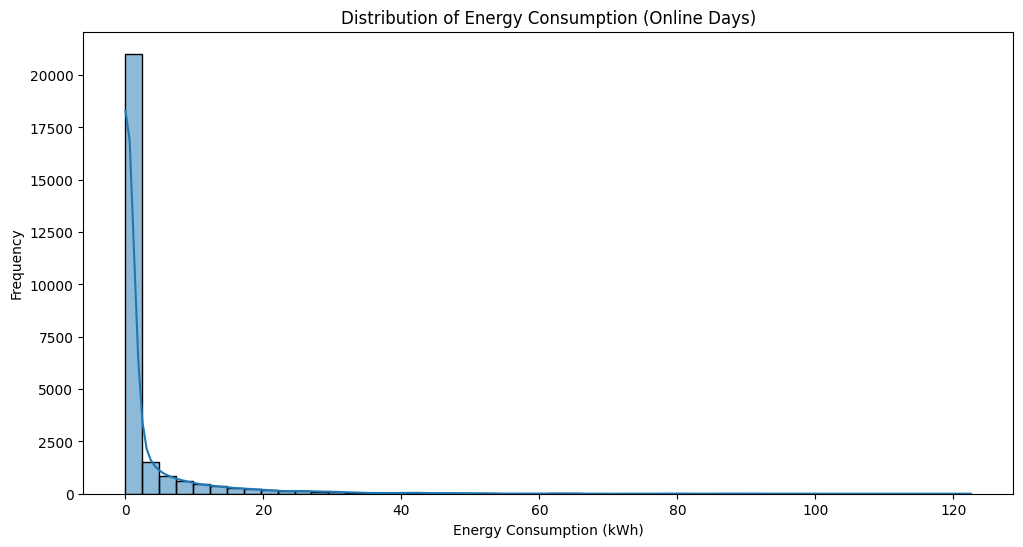

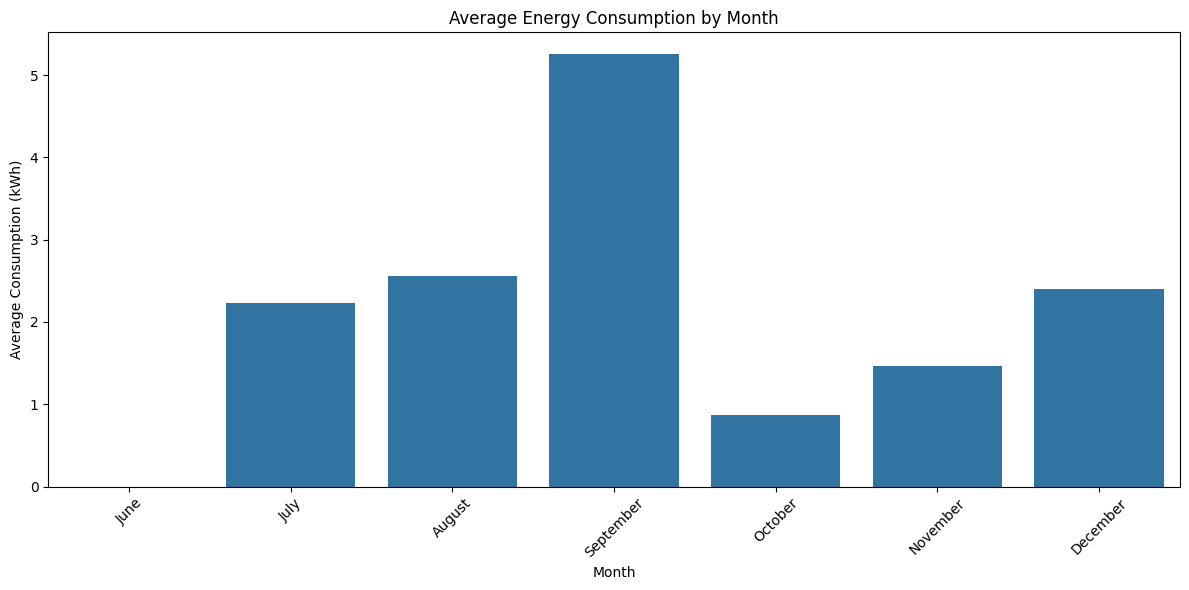

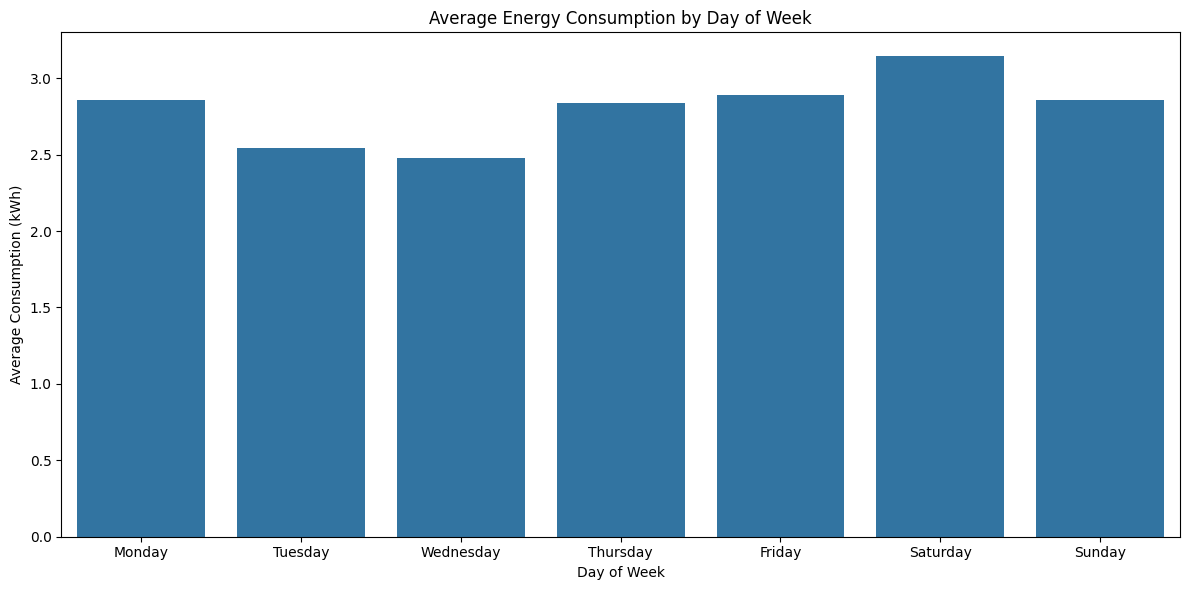

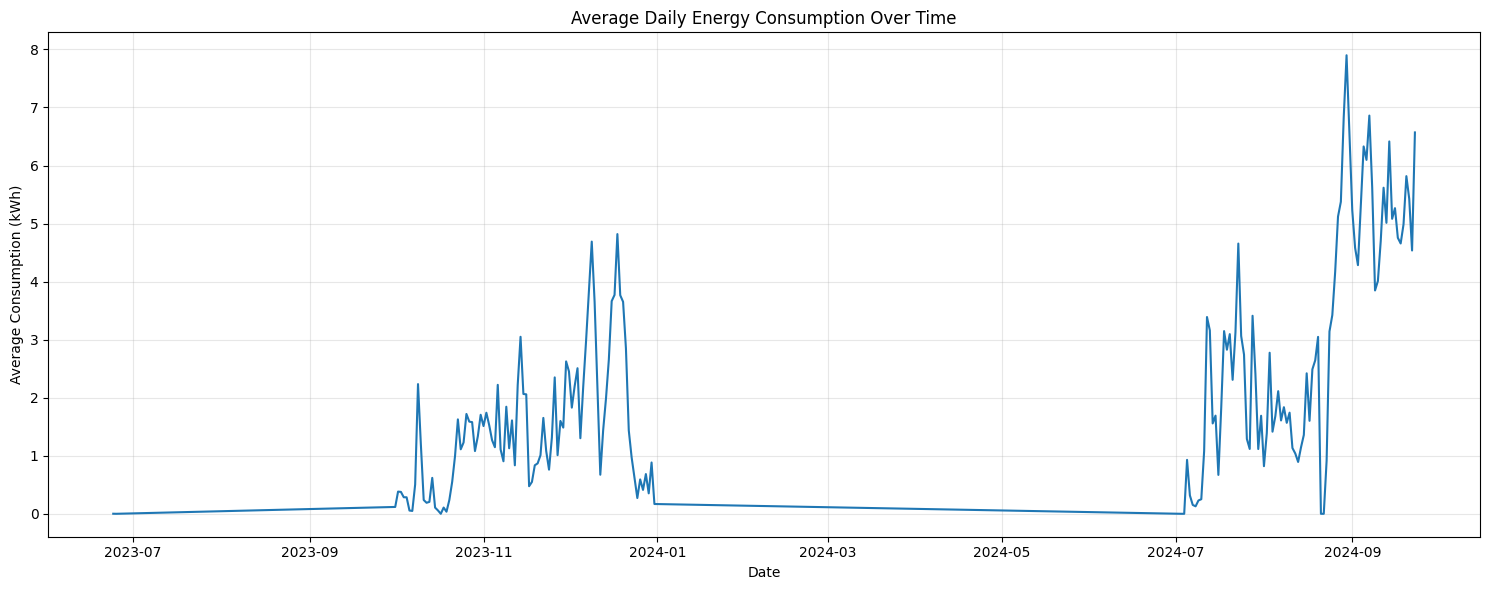

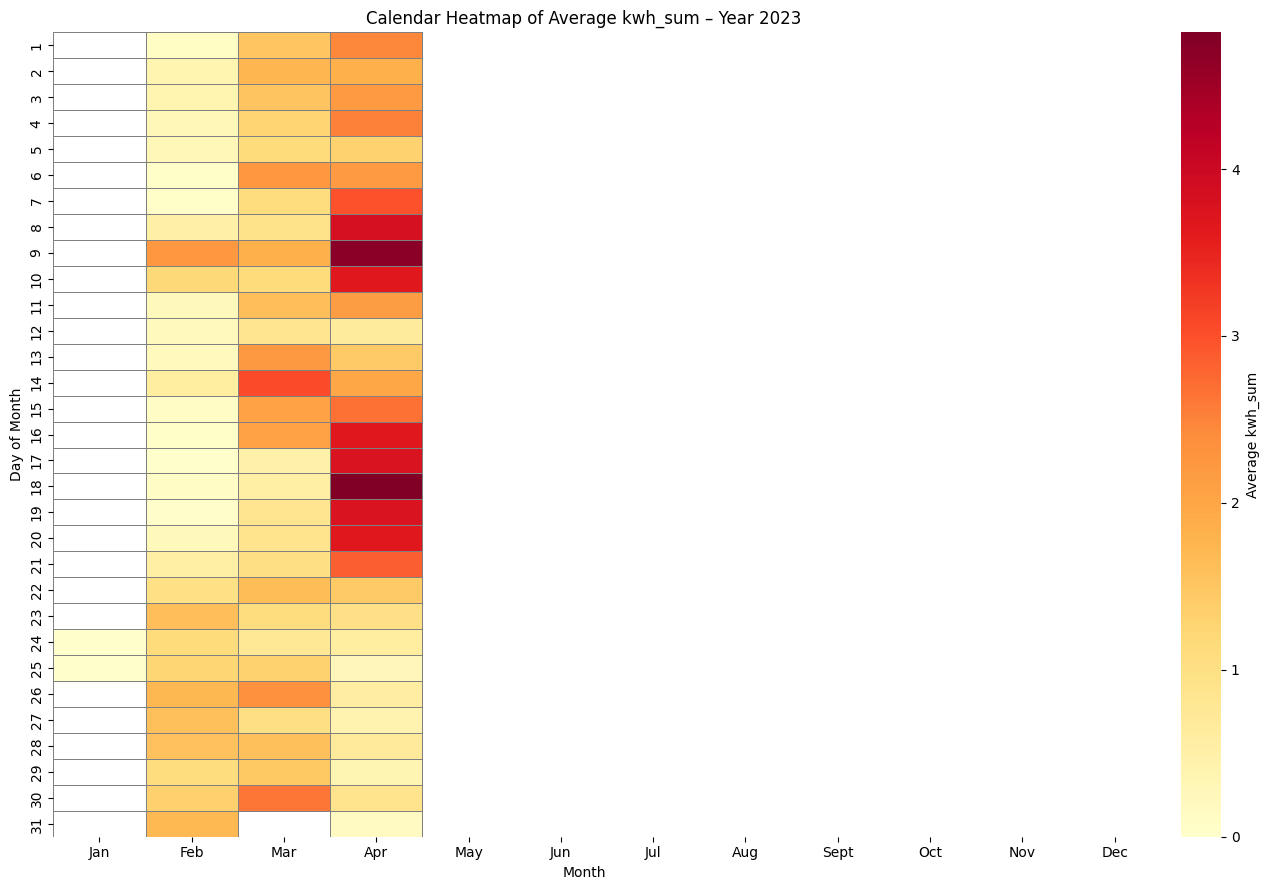

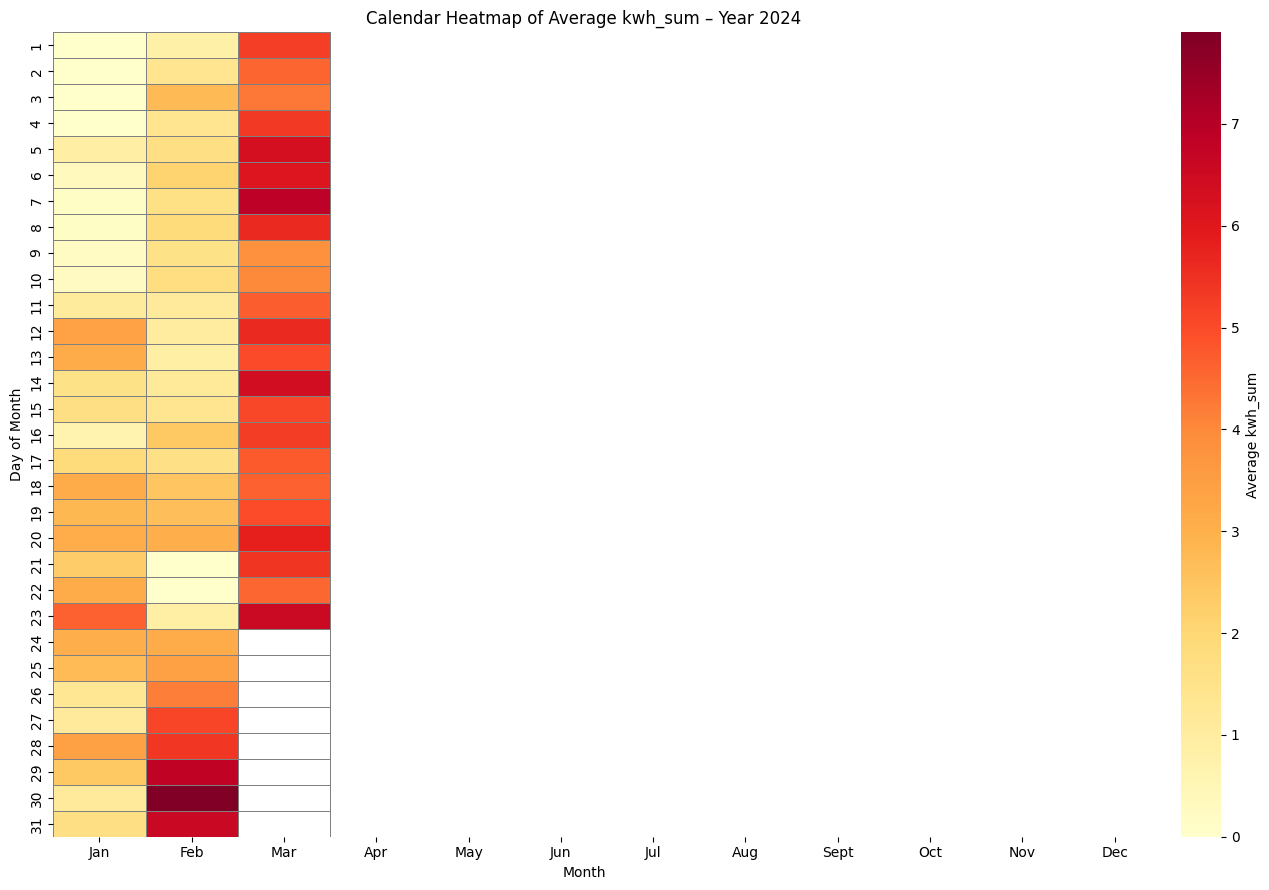

In [7]:
###########################################
# BASIC DATA INSPECTION (ONLINE_DATA)
###########################################
print("\n===== BASIC DATASET INFORMATION =====")
print(f"Shape: {online_data.shape}")
print(f"Time period: {online_data['Date'].min()} to {online_data['Date'].max()}")
print(f"Number of unique sources: {online_data['Source'].nunique()}")

# Convert Date to datetime (redundant if it's already date; safe to leave in if we want)
online_data['Date'] = pd.to_datetime(online_data['Date'])

###########################################
#  EDA & VISUALIZATIONS
###########################################
import calendar
import os

# Create EDA directory
os.makedirs('output/eda', exist_ok=True)

# Additional columns for EDA
online_data['Month'] = online_data['Date'].dt.month
online_data['Day'] = online_data['Date'].dt.day
online_data['Year'] = online_data['Date'].dt.year
online_data['DayOfWeek'] = online_data['Date'].dt.dayofweek
online_data['WeekOfYear'] = online_data['Date'].dt.isocalendar().week

# Convert device / user if needed
online_data['consumer_device'] = online_data['Source'].str.extract(r'consumer_device_(\d+)_data_user_\d+').astype(int)
online_data['data_user'] = online_data['Source'].str.extract(r'consumer_device_\d+_data_user_(\d+)').astype(int)

print("\n===== ENERGY CONSUMPTION STATISTICS =====")
print(online_data['kwh_sum'].describe())  # or 'kwh' if you’re using sum vs. single record

# 1) Distribution of energy consumption
plt.figure(figsize=(12, 6))
sns.histplot(online_data['kwh_sum'], bins=50, kde=True)
plt.title('Distribution of Energy Consumption (Online Days)')
plt.xlabel('Energy Consumption (kWh)')
plt.ylabel('Frequency')
plt.savefig('output/eda/energy_distribution.png')

# 2) Consumption by Month
monthly_consumption = online_data.groupby('Month')['kwh_sum'].agg(['mean', 'median', 'std', 'count']).reset_index()
monthly_consumption['month_name'] = monthly_consumption['Month'].apply(lambda x: calendar.month_name[x])
monthly_consumption = monthly_consumption.sort_values('Month')

plt.figure(figsize=(12, 6))
sns.barplot(x='month_name', y='mean', data=monthly_consumption)
plt.title('Average Energy Consumption by Month')
plt.xlabel('Month')
plt.ylabel('Average Consumption (kWh)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('output/eda/monthly_consumption.png')

# 3) Consumption by Day of Week
dow_consumption = online_data.groupby('DayOfWeek')['kwh_sum'].agg(['mean', 'median', 'std', 'count']).reset_index()
dow_consumption['day_name'] = dow_consumption['DayOfWeek'].apply(lambda x: calendar.day_name[x])
dow_consumption = dow_consumption.sort_values('DayOfWeek')

plt.figure(figsize=(12, 6))
sns.barplot(x='day_name', y='mean', data=dow_consumption)
plt.title('Average Energy Consumption by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Consumption (kWh)')
plt.tight_layout()
plt.savefig('output/eda/dayofweek_consumption.png')

# 4) Daily Trend
daily_avg = online_data.groupby('Date')['kwh_sum'].mean().reset_index()
plt.figure(figsize=(15, 6))
plt.plot(daily_avg['Date'], daily_avg['kwh_sum'])
plt.title('Average Daily Energy Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Average Consumption (kWh)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('output/eda/daily_consumption_trend.png')


###########################################
# CALENDAR HEATMAPS OF AVERAGE kwh_sum
###########################################
online_df = online_data.copy()
# Ensure 'Date' is a datetime, if not already
online_df['Date'] = pd.to_datetime(online_df['Date'])

# Extract components for pivoting
online_df['Year'] = online_df['Date'].dt.year
online_df['Month'] = online_df['Date'].dt.month
online_df['Day'] = online_df['Date'].dt.day

# For each unique year, pivot data so that:
# Rows = Day, Columns = Month, Values = AVERAGE kwh_sum
years = sorted(online_df['Year'].unique())

for year in years:
    year_df = online_df[online_df['Year'] == year].copy()
    
    # 1) Group by (Month, Day) and compute mean kwh_sum
    pivot_df = (
        year_df
        .groupby(['Month', 'Day'], as_index=False)['kwh_sum']
        .mean()
    )
    
    # 2) Pivot => row=Day, column=Month, value=mean(kwh_sum)
    heatmap_data = pivot_df.pivot(index='Day', columns='Month', values='kwh_sum')
    
    # Build month labels: e.g. 'Jan', 'Feb'...
    month_labels = [calendar.month_abbr[m] for m in range(1, 13)]
    
    # 3) Plot the heatmap
    plt.figure(figsize=(14, 9))
    ax = sns.heatmap(
        heatmap_data,
        cmap='YlOrRd',
        # You can set vmin/vmax if you want consistent color scaling across years
        # vmin=0, vmax=heatmap_data.max().max(),
        xticklabels=month_labels,
        yticklabels=range(1, 32),
        linewidths=0.5,
        linecolor='gray',
        cbar_kws={'label': 'Average kwh_sum'}
    )
    
    plt.title(f'Calendar Heatmap of Average kwh_sum – Year {year}')
    plt.xlabel('Month')
    plt.ylabel('Day of Month')
    plt.tight_layout()
    plt.show()
    plt.close()


#drop additionnal columns created for EDA
online_data.drop(['Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear'], axis=1, inplace=True)


**By analyzing the average daily consumption plot, we identified distinct behavioral patterns during specific date ranges. Based on these observations, our segmentation strategy is as follows:**  

- **Data1 (Aug–Sep 2024 & Oct 2023):** Late summer/early fall, where consumption is notably high. We trained a dedicated model for these intervals and assigned it a higher ensemble weight, since this segment closely aligns with the test period’s expected usage.  
- **Data2 (Nov–Dec 2023 & Jul 2024):** Winter and mid-summer, which show moderate consumption. A separate model captures these mid-range patterns.  
- **Data3 (All other intervals):** Primarily characterized by zero or very low usage, thereby isolating near-inactive periods so they do not overshadow higher-consumption dynamics.  
- **Data4 (Entire dataset):** A global model that unifies all intervals, ensuring broad coverage of overall consumption behavior.


# Advanced Feature Engineering

This section defines and implements:
1. A comprehensive set of Pakistan holidays
2. Advanced climate features
3. Cyclical temporal encodings
4. Temperature trend indicators
5. Special features for seasonal patterns in Kalam

**Reload filtred_online_days_enriched data again to avoid any conflicts with colomns that may be created during the EDA Process**

In [8]:

###########################################
# 1. LOADING ONLINE DAYS DATA FOR FEATURE ENGINEERING AND TRAINING

logger.info("Loading enriched online data...")
start_time = time.time()

# Daily enriched online data
online_data = pd.read_csv("output/filtred_online_days_enriched.csv")
logger.info(f"✓ Enriched online data loaded: {len(online_data):,} records")

# Date conversion
online_data['Date'] = pd.to_datetime(online_data['Date'])
if 'Year' not in online_data.columns:
    online_data['Year'] = online_data['Date'].dt.year  # fallback
else:
    online_data['Year'] = online_data['Year']

# Loading sample submission file
ss = pd.read_csv("datasets/SampleSubmission.csv")
logger.info(f"✓ Sample submission loaded: {len(ss):,} records")

# Loading climate data
climate_df = pd.read_excel('datasets/Climate Data/Climate Data/Kalam Climate Data.xlsx')
logger.info(f"✓ Climate data loaded: {len(climate_df):,} records")

elapsed = time.time() - start_time
logger.info(f"Data loading completed in {elapsed:.2f} seconds")

# Min/max dates
min_date = online_data['Date'].min()
max_date = online_data['Date'].max()
logger.info(f"Period covered: {min_date} to {max_date}")
years_available = online_data['Year'].unique()
logger.info(f"Available years in the data: {years_available}")

2025-04-22 12:06:17,618 - INFO - Loading enriched online data...
2025-04-22 12:06:17,718 - INFO - ✓ Enriched online data loaded: 26,298 records
2025-04-22 12:06:17,729 - INFO - ✓ Sample submission loaded: 6,014 records
2025-04-22 12:06:19,300 - INFO - ✓ Climate data loaded: 12,228 records
2025-04-22 12:06:19,302 - INFO - Data loading completed in 1.68 seconds
2025-04-22 12:06:19,305 - INFO - Period covered: 2023-06-24 00:00:00 to 2024-09-23 00:00:00
2025-04-22 12:06:19,307 - INFO - Available years in the data: [2024 2023]


In [9]:
###########################################
# 2. DEFINING PAKISTAN HOLIDAYS AND SEASONS (KALAM)
###########################################
def get_pakistan_holidays(start_date, end_date):
    """Creates a list of Pakistan holidays for a given period."""
    # Convert to datetime if not already done
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # List of fixed holidays (approx. for lunar holidays)
    holidays = []
    
    # 2023 holidays
    if start_date <= pd.to_datetime("2023-12-31"):
        holidays.extend([
            ("2023-02-05", "Kashmir Day"),
            ("2023-03-23", "Pakistan Day"),
            ("2023-05-01", "Labour Day"),
            ("2023-06-29", "Eid ul Adha"), # approx dates for lunar calendars
            ("2023-06-30", "Eid ul Adha"),
            ("2023-07-01", "Eid ul Adha"),
            ("2023-08-14", "Independence Day"),
            ("2023-09-27", "Eid Milad-un-Nabi"),
            ("2023-11-09", "Iqbal Day"),
            ("2023-12-25", "Quaid-e-Azam Day/Christmas")
        ])
    
    # 2024 holidays
    if start_date <= pd.to_datetime("2024-12-31") and end_date >= pd.to_datetime("2024-01-01"):
        holidays.extend([
            ("2024-02-05", "Kashmir Day"),
            ("2024-03-23", "Pakistan Day"),
            ("2024-05-01", "Labour Day"),
            ("2024-06-17", "Eid ul Adha"), # approx dates
            ("2024-06-18", "Eid ul Adha"),
            ("2024-06-19", "Eid ul Adha"),
            ("2024-08-14", "Independence Day"),
            ("2024-09-16", "Eid Milad-un-Nabi"),
            ("2024-11-09", "Iqbal Day"),
            ("2024-12-25", "Quaid-e-Azam Day/Christmas")
        ])
    
    # Filter dates in the specified range
    holiday_dates = [pd.to_datetime(date) for date, _ in holidays 
                     if pd.to_datetime(date) >= start_date and pd.to_datetime(date) <= end_date]
    
    return holiday_dates

###########################################
# 3. ADVANCED FUNCTION TO ADD FEATURES
###########################################
def add_advanced_features(df, climate_df):
    """Adds advanced features for energy prediction."""
    logger.info("Adding advanced features...")
    
    # Date conversion if necessary
    climate_df['Date Time'] = pd.to_datetime(climate_df['Date Time'])
    
    # Preparing climate data with advanced statistics
    climate_daily = (
        climate_df.groupby(climate_df['Date Time'].dt.date)
        .agg({
            'Temperature (°C)': ['mean', 'min', 'max', 'std'],
            'Dewpoint Temperature (°C)': ['mean', 'min', 'max'],
            'U Wind Component (m/s)': ['mean', 'max'],
            'V Wind Component (m/s)': ['mean', 'max'],
            'Total Precipitation (mm)': ['sum', 'max'],
            'Snowfall (mm)': ['sum', 'max'],
            'Snow Cover (%)': ['mean', 'max'],
        })
        .reset_index()
    )
    
    # Flatten multi-index column names
    climate_daily.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in climate_daily.columns]
    
    # Rename the column correctly after flattening
    if 'Date Time_' in climate_daily.columns:
        climate_daily.rename(columns={'Date Time_': 'Date'}, inplace=True)
    elif 'Date Time' in climate_daily.columns:
        climate_daily.rename(columns={'Date Time': 'Date'}, inplace=True)
    else:
        # Fallback in case the column name is different
        first_col = climate_daily.columns[0]
        climate_daily.rename(columns={first_col: 'Date'}, inplace=True)
        logger.warning(f"Unable to find 'Date Time', used {first_col} as Date column")
    
    climate_daily['Date'] = pd.to_datetime(climate_daily['Date'])
    
    # Merge with climate data
    df = df.merge(climate_daily, on='Date', how='left')
    
    # Calculate temperature variations
    df['temp_daily_range'] = df['Temperature (°C)_max'] - df['Temperature (°C)_min']
    
    # Extract consumer_device / data_user if not already done
    if 'consumer_device' not in df.columns:
        df['consumer_device'] = df['Source'].str.extract(r'consumer_device_(\d+)_data_user_\d+').astype(int)
        df['data_user'] = df['Source'].str.extract(r'consumer_device_\d+_data_user_(\d+)').astype(int)
    
    #-----------------------------------------
    # 1. CYCLICAL TEMPORAL FEATURES
    #-----------------------------------------
    # Cyclical encoding of day of week (0-6)
    df['day_of_week'] = df['Date'].dt.dayofweek
    df['dow_sin'] = np.sin(df['day_of_week'] * (2 * np.pi / 7))
    df['dow_cos'] = np.cos(df['day_of_week'] * (2 * np.pi / 7))
    
    # Cyclical encoding of day of year (1-366)
    df['day_of_year'] = df['Date'].dt.dayofyear
    df['doy_sin'] = np.sin(df['day_of_year'] * (2 * np.pi / 365.25))
    df['doy_cos'] = np.cos(df['day_of_year'] * (2 * np.pi / 365.25))
    
    # Cyclical encoding of month (1-12)
    df['Month'] = df['Date'].dt.month
    df['month_sin'] = np.sin(df['Month'] * (2 * np.pi / 12))
    df['month_cos'] = np.cos(df['Month'] * (2 * np.pi / 12))
    
    # Cyclical encoding of week (1-53)
    df['Week'] = df['Date'].dt.isocalendar().week
    df['week_sin'] = np.sin(df['Week'] * (2 * np.pi / 53))
    df['week_cos'] = np.cos(df['Week'] * (2 * np.pi / 53))
    
    # Identification of seasons (Kalam has very distinct seasons)
    # For Pakistan: Winter (Dec-Feb), Spring (Mar-May), Summer (Jun-Aug), Fall (Sep-Nov)
    season_map = {1: 1, 2: 1, 3: 2, 4: 2, 5: 2, 6: 3, 7: 3, 8: 3, 9: 4, 10: 4, 11: 4, 12: 1}
    df['season'] = df['Month'].map(season_map)
    df['season_sin'] = np.sin(df['season'] * (2 * np.pi / 4))
    df['season_cos'] = np.cos(df['season'] * (2 * np.pi / 4))
    
    # Weekend indicator
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    #-----------------------------------------
    # 2. HOLIDAYS AND MORE GRANULAR SEASONAL FEATURES
    #-----------------------------------------
    holidays = get_pakistan_holidays(df['Date'].min(), df['Date'].max())
    df['is_holiday'] = df['Date'].isin(holidays).astype(int)
    
    # Week of the year
    df['week_in_year'] = df['Date'].dt.isocalendar().week
    
    # Days since the beginning of each season
    spring_start, spring_end = 60, 151  # Mar 1 - May 31 (approx days of year)
    summer_start, summer_end = 152, 243  # Jun 1 - Aug 31
    fall_start, fall_end = 244, 334  # Sep 1 - Nov 30
    # Winter wraps around year end
    
    df['day_in_season'] = np.nan
    
    # Calculate days since start of each season
    mask_spring = (df['day_of_year'] >= spring_start) & (df['day_of_year'] <= spring_end)
    mask_summer = (df['day_of_year'] >= summer_start) & (df['day_of_year'] <= summer_end)
    mask_fall = (df['day_of_year'] >= fall_start) & (df['day_of_year'] <= fall_end)
    mask_winter = (~mask_spring) & (~mask_summer) & (~mask_fall)
    
    df.loc[mask_spring, 'day_in_season'] = df.loc[mask_spring, 'day_of_year'] - spring_start
    df.loc[mask_summer, 'day_in_season'] = df.loc[mask_summer, 'day_of_year'] - summer_start
    df.loc[mask_fall, 'day_in_season'] = df.loc[mask_fall, 'day_of_year'] - fall_start
    df.loc[mask_winter & (df['day_of_year'] >= 335), 'day_in_season'] = df.loc[mask_winter & (df['day_of_year'] >= 335), 'day_of_year'] - 335
    df.loc[mask_winter & (df['day_of_year'] < 60), 'day_in_season'] = df.loc[mask_winter & (df['day_of_year'] < 60), 'day_of_year'] + 31  # Days after Jan 1
    
    # Create cyclical features for day in season
    df['day_in_season_sin'] = np.sin(df['day_in_season'] * (2 * np.pi / 90))  # ~90 days per season
    df['day_in_season_cos'] = np.cos(df['day_in_season'] * (2 * np.pi / 90))
    
    # Ramadan dates (important for Pakistan)
    ramadan_2023_start = pd.to_datetime('2023-03-23')
    ramadan_2023_end = pd.to_datetime('2023-04-21')
    ramadan_2024_start = pd.to_datetime('2024-03-11')  
    ramadan_2024_end = pd.to_datetime('2024-04-09')
    
    df['is_ramadan'] = (
        ((df['Date'] >= ramadan_2023_start) & (df['Date'] <= ramadan_2023_end)) | 
        ((df['Date'] >= ramadan_2024_start) & (df['Date'] <= ramadan_2024_end))
    ).astype(int)
    
    #-----------------------------------------
    # 3. CLIMATE-RELATED FEATURES
    #-----------------------------------------
    # Temperature and dew point
    df['temp_dew_diff'] = df['Temperature (°C)_mean'] - df['Dewpoint Temperature (°C)_mean']
    
    # Wind speed calculated from U and V components
    df['wind_speed'] = np.sqrt(df['U Wind Component (m/s)_mean']**2 + df['V Wind Component (m/s)_mean']**2)
    df['wind_speed_max'] = np.sqrt(df['U Wind Component (m/s)_max']**2 + df['V Wind Component (m/s)_max']**2)
    
    # Precipitation/snow ratio
    df['precip_snow_ratio'] = df['Total Precipitation (mm)_sum'] / (df['Snowfall (mm)_sum'] + 1e-6)
    
    # Degree days (heating/cooling) - base 18°C
    df['heating_degree_days'] = np.maximum(18 - df['Temperature (°C)_mean'], 0)
    df['cooling_degree_days'] = np.maximum(df['Temperature (°C)_mean'] - 18, 0)
    
    # Temperature-day of week interaction
    for day in range(7):
        df[f'temp_dow_{day}'] = np.where(df['day_of_week'] == day, df['Temperature (°C)_mean'], 0)
    
    #-----------------------------------------
    # 4. ADVANCED TEMPERATURE TREND FEATURES
    #-----------------------------------------
    # Sort data to calculate correct trends
    df = df.sort_values(['Source', 'Date']).reset_index(drop=True)
    
    # Create trends by source
    for source in df['Source'].unique():
        source_mask = df['Source'] == source
        if sum(source_mask) > 7:  # At least one week of data
            # Exponential moving averages
            df.loc[source_mask, 'temp_ewm_3d'] = df.loc[source_mask, 'Temperature (°C)_mean'].ewm(span=3).mean()
            df.loc[source_mask, 'temp_ewm_7d'] = df.loc[source_mask, 'Temperature (°C)_mean'].ewm(span=7).mean()
            
            # Temperature volatility (rolling standard deviation)
            df.loc[source_mask, 'temp_volatility_7d'] = df.loc[source_mask, 'Temperature (°C)_mean'].rolling(window=7, min_periods=1).std()
            
            # Temperature acceleration (change of rate of change)
            temp = df.loc[source_mask, 'Temperature (°C)_mean']
            df.loc[source_mask, 'temp_acceleration'] = temp.diff().diff().fillna(0)
            
            # Temperature trend direction (up or down)
            df.loc[source_mask, 'temp_trend_direction'] = np.sign(temp.diff(periods=3)).fillna(0)
            
            # Temperature extreme indicator (sudden peaks or drops)
            rolling_mean = temp.rolling(window=7, min_periods=1).mean()
            rolling_std = temp.rolling(window=7, min_periods=1).std().fillna(1)  # Avoid division by zero
            df.loc[source_mask, 'temp_extreme'] = ((temp - rolling_mean).abs() / rolling_std).fillna(0)


    # Convert categorical columns
    df['Source'] = df['Source'].astype('category')
    if 'consumer_device' in df.columns:
        df['consumer_device'] = df['consumer_device'].astype('category')
    if 'data_user' in df.columns:
        df['data_user'] = df['data_user'].astype('category')
    
    # Fill NaNs
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_cols] = df[numeric_cols].fillna(0)

    
    return df

# Data Segmentation

To capture different seasonal patterns, I segment the data into four groups:
1. Data1: Late summer/early fall (Aug-Sep 2024, Oct 2023)
2. Data2: Winter and mid-summer (Nov-Dec 2023, Jul 2024)
3. Data3: All other periods with distinct patterns
4. Data4: The complete dataset for a global model

2025-04-22 12:09:29,459 - INFO - Separating data according to new ranges...


2025-04-22 12:09:29,475 - INFO - Data1: 14,983 records
2025-04-22 12:09:29,476 - INFO - Data2: 11,313 records
2025-04-22 12:09:29,477 - INFO - Data3: 2 records


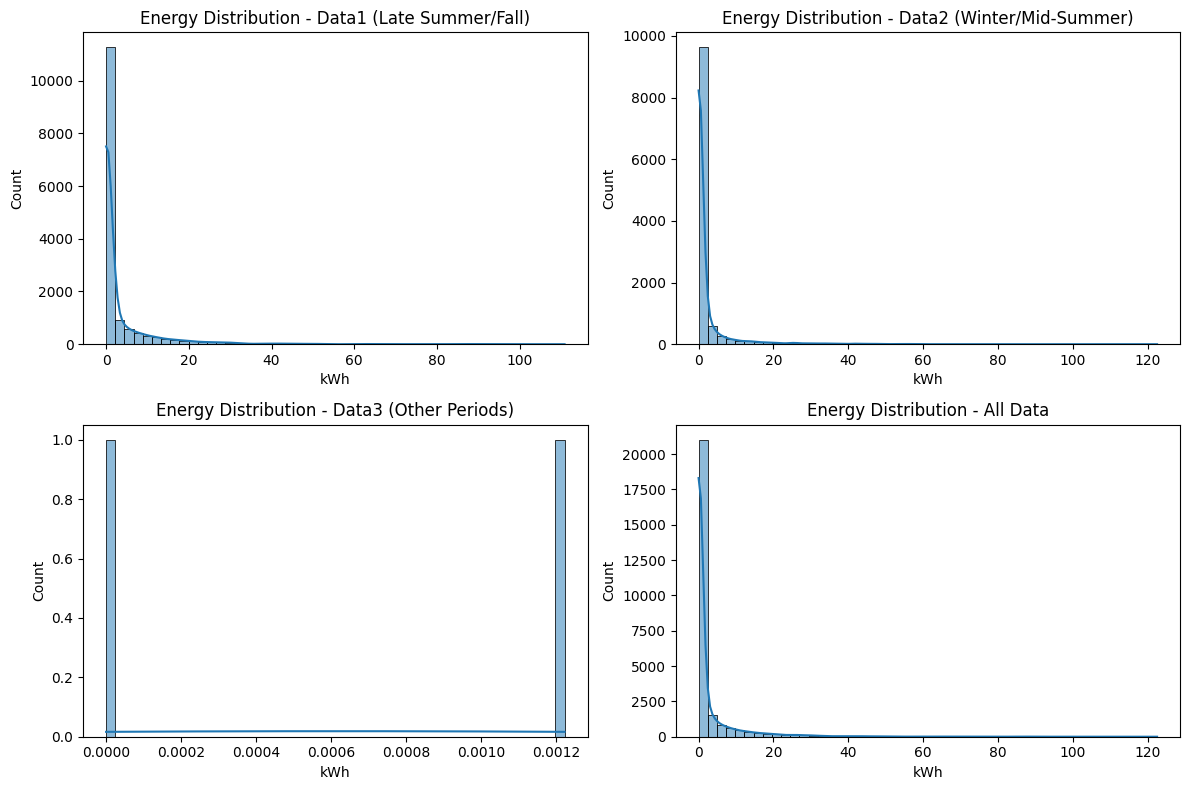

2025-04-22 12:09:30,295 - INFO - Preparing 4 complete datasets with advanced features...
2025-04-22 12:09:30,295 - INFO - Creating complete dataset for period 2023-10-01 00:00:00 to 2024-09-23 00:00:00
2025-04-22 12:09:32,058 - INFO - Complete data after filtering: 14983 records
2025-04-22 12:09:32,058 - INFO - Creating complete dataset for period 2023-11-01 00:00:00 to 2024-07-31 00:00:00
2025-04-22 12:09:33,752 - INFO - Complete data after filtering: 11313 records
2025-04-22 12:09:33,752 - INFO - Creating complete dataset for period 2023-06-24 00:00:00 to 2023-06-25 00:00:00
2025-04-22 12:09:33,758 - INFO - Complete data after filtering: 2 records
2025-04-22 12:09:33,758 - INFO - Creating complete dataset for period 2023-06-24 00:00:00 to 2024-09-23 00:00:00
2025-04-22 12:09:36,003 - INFO - Complete data after filtering: 26298 records
2025-04-22 12:09:36,003 - INFO - Adding advanced features...
2025-04-22 12:09:37,960 - INFO - Adding advanced features...
2025-04-22 12:09:39,703 - INF

,Data1,Data2,Data3,Data4
Feature Count,86,86,80,86


In [10]:
###########################################
# DATA SEGMENTATION & PREPARATION
###########################################
logger.info("Separating data according to new ranges...")

# Data1 = August 1 -> September 23, 2024, AND all October 2023
mask_data1 = (
    ((online_data['Date'] >= '2024-08-01') & (online_data['Date'] <= '2024-09-23')) |
    ((online_data['Date'] >= '2023-10-01') & (online_data['Date'] <= '2023-10-31'))
)
data1 = online_data[mask_data1].copy()

# Data2 = November 1 -> December 31, 2023, AND all July 2024
mask_data2 = (
    ((online_data['Date'] >= '2023-11-01') & (online_data['Date'] <= '2023-12-31')) |
    ((online_data['Date'] >= '2024-07-01') & (online_data['Date'] <= '2024-07-31'))
)
data2 = online_data[mask_data2].copy()

# Data3 = the rest
mask_data3 = ~(mask_data1 | mask_data2)
data3 = online_data[mask_data3].copy()

logger.info(f"Data1: {len(data1):,} records")
logger.info(f"Data2: {len(data2):,} records")
logger.info(f"Data3: {len(data3):,} records")

# Visualize the data distribution across segments
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.histplot(data1['kwh_sum'], bins=50, kde=True)
plt.title('Energy Distribution - Data1 (Late Summer/Fall)')
plt.xlabel('kWh')

plt.subplot(2, 2, 2)
sns.histplot(data2['kwh_sum'], bins=50, kde=True)
plt.title('Energy Distribution - Data2 (Winter/Mid-Summer)')
plt.xlabel('kWh')

plt.subplot(2, 2, 3)
sns.histplot(data3['kwh_sum'], bins=50, kde=True)
plt.title('Energy Distribution - Data3 (Other Periods)')
plt.xlabel('kWh')

plt.subplot(2, 2, 4)
sns.histplot(online_data['kwh_sum'], bins=50, kde=True)
plt.title('Energy Distribution - All Data')
plt.xlabel('kWh')

plt.tight_layout()
plt.show()

# Function to prepare complete datasets
def prepare_complete_data(agg_data, start_date=None, end_date=None):
    """Creates a complete dataframe (missing dates) for each Source."""
    if len(agg_data) == 0:
        logger.warning("Empty dataset, creation impossible.")
        return pd.DataFrame()
    
    if start_date is None:
        start_date = agg_data['Date'].min()
    if end_date is None:
        end_date = agg_data['Date'].max()
    
    logger.info(f"Creating complete dataset for period {start_date} to {end_date}")
    
    complete_data = pd.DataFrame()
    date_rng = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Determine which column contains consumption data
    kwh_col = 'kwh_sum' if 'kwh_sum' in agg_data.columns else 'kwh'
    
    for src in agg_data['Source'].unique():
        subset = agg_data[agg_data['Source'] == src].copy()
        rng_df = pd.DataFrame({'Date': date_rng})
        rng_df['Source'] = src
        
        merged = pd.merge(rng_df, subset, on=['Date','Source'], how='left')
        # Remove rows without consumption (as we're already dealing with online only)
        merged.dropna(subset=[kwh_col], inplace=True)
        
        complete_data = pd.concat([complete_data, merged], ignore_index=True)
    
    logger.info(f"Complete data after filtering: {len(complete_data)} records")
    return complete_data

# Prepare and enhance the datasets
logger.info("Preparing 4 complete datasets with advanced features...")

# Dataset preparation
complete_data_1 = prepare_complete_data(data1)
complete_data_2 = prepare_complete_data(data2)
complete_data_3 = prepare_complete_data(data3)
complete_data_4 = prepare_complete_data(online_data)  # The whole period

# Adding advanced features
complete_data_1 = add_advanced_features(complete_data_1, climate_df)
complete_data_2 = add_advanced_features(complete_data_2, climate_df)
complete_data_3 = add_advanced_features(complete_data_3, climate_df)
complete_data_4 = add_advanced_features(complete_data_4, climate_df)

# Display feature counts
feature_counts = pd.DataFrame({
    'Data1': len(complete_data_1.columns),
    'Data2': len(complete_data_2.columns),
    'Data3': len(complete_data_3.columns),
    'Data4': len(complete_data_4.columns)
}, index=['Feature Count'])
display(feature_counts)

# Model Training Functions

This section implements:

1. A cross-validation training function with Bayesian optimization for ensemble weights
2. A direct training function for smaller datasets
3. A prediction function that handles both ensemble and single models

The CV training function trains 7 different LightGBM models with varied configurations, then uses Bayesian optimization to find the optimal weights for combining their predictions.

In [ ]:

def  train_model_cv(data, model_name, n_folds=5):
    """
    Trains a stack of 7 LGBM models with different parameters.
    Uses Bayesian optimization to find optimal weights.
    Returns: (models, used_columns, cv_scores, oof_predictions, oof_rmse)
    """
    logger.info(f"========== START TRAINING {model_name} ==========")
    logger.info(f"Training {model_name} with stacking of 7 LGBMs (CV {n_folds}-folds)...")
    logger.info(f"Input data: {len(data)} samples with {len(data.columns)} columns")
    
    start_time = time.time()
    
    # Determine target column (kwh or kwh_sum)
    target_col = 'kwh_sum' if 'kwh_sum' in data.columns else 'kwh'
    logger.info(f"Detected target column: {target_col}")
    
    # List of columns to exclude from training
    exclude_cols = [
        'Date', 'kwh', 'kwh_sum', 'Year_Week', 'is_offline', 
        'Month', 'day_of_week', 'day_of_year', 'Week', 'Year',
        'consumer_device', 'data_user', 'current_mean', 'current_std', 'current_min', 'current_max',
        'v_red_mean', 'v_red_std', 'v_red_min', 'v_red_max', 
        'v_blue_mean', 'v_blue_std', 'v_blue_min', 'v_blue_max',
        'v_yellow_mean', 'v_yellow_std', 'v_yellow_min', 'v_yellow_max',
        'power_factor_mean', 'power_factor_min', 'power_factor_max'
    ]
    
    # Remove columns with too many NaNs
    nan_cols = []
    for col in data.columns:
        if col not in exclude_cols and data[col].isna().mean() > 0.5:  # More than 50% NaN
            exclude_cols.append(col)
            nan_cols.append(col)
    
    if nan_cols:
        logger.info(f"Columns excluded due to too many NaNs: {', '.join(nan_cols)}")
    
    logger.info(f"Total of {len(exclude_cols)} columns excluded from training")
    
    X = data.drop(columns=exclude_cols, errors='ignore')
    y = data[target_col].values
    #y = np.log1p(np.maximum(0, y_raw))
    
    logger.info(f"Prepared dataset: X shape={X.shape}, y shape={y.shape}")
    logger.info(f"Target statistics: min={y.min():.4f}, max={y.max():.4f}, mean={y.mean():.4f}, median={np.median(y):.4f}")
    
    # Identification of categorical features
    cat_feats = ['Source']
    if 'is_three_phase' in X.columns:
        cat_feats.append('is_three_phase')
    if 'season' in X.columns:
        cat_feats.append('season')
    
    logger.info(f"Detected categorical features: {', '.join(cat_feats)}")
    
    # 7 different LightGBM configurations
    lgbm_configs = [
        # Model 1: Precise, more conservative (original)
        {
            'name': 'precise',
            'params': {
                'n_estimators': 2000,
                'learning_rate': 0.01,
                'max_depth': 8,
                'num_leaves': 31,
                'colsample_bytree': 0.8,
                'subsample': 0.8,
                'reg_alpha': 0.1,
                'reg_lambda': 0.1,
                'min_child_weight': 10,
                'random_state': 42,
                'objective': 'rmse',
                'metric': 'rmse',
                'verbose': -1,
                'early_stopping_rounds': 100
            }
        },
        # Model 2: More aggressive on feature selection (original)
        {
            'name': 'feature_selective',
            'params': {
                'n_estimators': 1500,
                'learning_rate': 0.02,
                'max_depth': 6,
                'colsample_bytree': 0.6,
                'subsample': 0.9,
                'reg_alpha': 1.0,
                'reg_lambda': 0.1,
                'feature_fraction': 0.7,
                'random_state': 42,
                'objective': 'rmse',
                'metric': 'rmse',
                'verbose': -1,
                'early_stopping_rounds': 100
            }
        },
        # Model 3: Focus on robustness to outliers (original)
        {
            'name': 'robust',
            'params': {
                'n_estimators': 1000,
                'learning_rate': 0.03,
                'max_depth': 5,
                'colsample_bytree': 0.9,
                'subsample': 0.7,
                'reg_alpha': 0.5,
                'reg_lambda': 1.0,
                'min_data_in_leaf': 20,
                'random_state': 42,
                'objective': 'rmse',
                'metric': 'rmse',
                'verbose': -1,
                'early_stopping_rounds': 100
            }
        },
        # Model 4: Very deep with many trees (new)
        {
            'name': 'deep_forest',
            'params': {
                'n_estimators': 3000,
                'learning_rate': 0.005,
                'max_depth': 12,
                'num_leaves': 64,
                'colsample_bytree': 0.75,
                'subsample': 0.75,
                'reg_alpha': 0.2,
                'reg_lambda': 0.2,
                'min_child_weight': 5,
                'random_state': 42,
                'objective': 'rmse',
                'metric': 'rmse',
                'verbose': -1,
                'early_stopping_rounds': 150
            }
        },
        # Model 5: Highly regularized (new)
        {
            'name': 'highly_regularized',
            'params': {
                'n_estimators': 1200,
                'learning_rate': 0.02,
                'max_depth': 4,
                'num_leaves': 16,
                'colsample_bytree': 0.7,
                'subsample': 0.8,
                'reg_alpha': 2.0,
                'reg_lambda': 2.0,
                'min_child_weight': 15,
                'min_data_in_leaf': 25,
                'random_state': 42,
                'objective': 'rmse',
                'metric': 'rmse',
                'verbose': -1,
                'early_stopping_rounds': 100
            }
        },
        # Model 6: Very fast with high learning rate (new)
        {
            'name': 'fast_learner',
            'params': {
                'n_estimators': 800,
                'learning_rate': 0.08,
                'max_depth': 6,
                'num_leaves': 32,
                'colsample_bytree': 0.85,
                'subsample': 0.85,
                'reg_alpha': 0.3,
                'reg_lambda': 0.3,
                'min_child_weight': 8,
                'random_state': 42,
                'objective': 'rmse',
                'metric': 'rmse',
                'verbose': -1,
                'early_stopping_rounds': 80
            }
        },
        # Model 7: Optimized for bias-variance trade-off (new)
        {
            'name': 'balanced',
            'params': {
                'n_estimators': 1800,
                'learning_rate': 0.015,
                'max_depth': 7,
                'num_leaves': 40,
                'colsample_bytree': 0.75,
                'subsample': 0.85,
                'reg_alpha': 0.4,
                'reg_lambda': 0.4,
                'min_child_weight': 12,
                'bagging_freq': 5,
                'random_state': 42,
                'objective': 'rmse',
                'metric': 'rmse',
                'verbose': -1,
                'early_stopping_rounds': 120
            }
        }
    ]
    
    logger.info(f"Configuration of {len(lgbm_configs)} LightGBM models with different parameters")
    
    # Cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    models = []  # Final model list to return (consistent with original function)
    optimal_weights_list = []  # Storage for optimal weights for each fold
    cv_scores = []
    oof_preds = np.zeros(len(data))
    oof_base_preds = np.zeros((len(data), len(lgbm_configs)))
    
    # Training of level 1 (base) models
    logger.info(f"Starting training with {n_folds}-fold cross-validation")
    
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X)):
        fold_start_time = time.time()
        logger.info(f"=====================")
        logger.info(f"Fold {fold+1}/{n_folds} for {model_name}")
        logger.info(f"Train: {len(tr_idx)} samples, Validation: {len(val_idx)} samples")
        
        X_train, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_train, y_val = y[tr_idx], y[val_idx]
        
        logger.info(f"y_train statistics: min={y_train.min():.4f}, max={y_train.max():.4f}, mean={y_train.mean():.4f}")
        logger.info(f"y_val statistics: min={y_val.min():.4f}, max={y_val.max():.4f}, mean={y_val.mean():.4f}")
        
        fold_models = []
        fold_preds = np.zeros((len(X_val), len(lgbm_configs)))
        
        # Training each base model
        for i, config in enumerate(lgbm_configs):
            model_start_time = time.time()
            logger.info(f"  ---------------------")
            logger.info(f"  Training base model {i+1}/{len(lgbm_configs)} ({config['name']})...")
            logger.info(f"  Parameters: {json.dumps(config['params'], indent=2)}")
            
            model = LGBMRegressor(**config['params'])
            
            try:
                logger.info(f"  Starting training...")
                model.fit(
                    X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    categorical_feature=cat_feats
                )
                logger.info(f"  Training completed successfully in {time.time() - model_start_time:.2f} seconds")
                logger.info(f"  Best iteration: {model.best_iteration_}")
                
                # Predictions on validation set
                val_preds = model.predict(X_val)
                fold_preds[:, i] = val_preds
                oof_base_preds[val_idx, i] = val_preds
                
                fold_models.append(model)
                
                # Display metrics for this model
                rmse = np.sqrt(mean_squared_error(y_val, val_preds))
                logger.info(f"  Model {config['name']} - RMSE: {rmse:.6f}")
                logger.info(f"  Prediction statistics: min={val_preds.min():.4f}, max={val_preds.max():.4f}, mean={val_preds.mean():.4f}")
                
            except Exception as e:
                logger.error(f"  ERROR during training of model {config['name']}: {str(e)}")
                # Placeholder model with default parameters if training fails
                placeholder_model = LGBMRegressor(n_estimators=100)
                placeholder_model.fit(X_train, y_train)
                fold_models.append(placeholder_model)
                fold_preds[:, i] = placeholder_model.predict(X_val)
                oof_base_preds[val_idx, i] = fold_preds[:, i]
        
        # Instead of using a meta-model, find optimal weights with Bayesian optimization
        logger.info(f"  ---------------------")
        logger.info(f"  Searching for optimal weights with Bayesian optimization...")
        
        # Objective function for Bayesian optimization
        def objective_function(**weights):
            # Convert dictionary to array
            w = np.array([weights[f'w{i}'] for i in range(len(lgbm_configs))])
            
            # Normalize weights to sum to 1
            w = w / np.sum(w)
            
            # Weighted prediction
            weighted_pred = np.zeros(len(y_val))
            for i in range(len(lgbm_configs)):
                weighted_pred += w[i] * fold_preds[:, i]
            
            # Calculate negative error (because we maximize)
            neg_rmse = -np.sqrt(mean_squared_error(y_val, weighted_pred))
            return neg_rmse
        
        # Define bounds for optimization - all weights between 0 and 1
        pbounds = {f'w{i}': (0, 1) for i in range(len(lgbm_configs))}
        
        # Run Bayesian optimization
        optimizer = BayesianOptimization(
            f=objective_function,
            pbounds=pbounds,
            random_state=42,
            verbose=0
        )
        
        optimizer.maximize(init_points=10, n_iter=50)
        
        # Get best parameters and normalize
        best_params = optimizer.max['params']
        optimal_weights = np.array([best_params[f'w{i}'] for i in range(len(lgbm_configs))])
        optimal_weights = optimal_weights / np.sum(optimal_weights)
        optimal_weights_list.append(optimal_weights)
        
        # Record optimal weights
        logger.info(f"  Optimal weights found: {', '.join([f'{w:.4f}' for w in optimal_weights])}")
        
        # Calculate final predictions with optimal weights
        final_val_preds = np.zeros(len(y_val))
        for i in range(len(lgbm_configs)):
            final_val_preds += optimal_weights[i] * fold_preds[:, i]
        
        oof_preds[val_idx] = final_val_preds
        
        # Calculate final RMSE
        rmse = np.sqrt(mean_squared_error(y_val, final_val_preds))
        cv_scores.append(rmse)
        logger.info(f"  Bayesian optimization - RMSE: {rmse:.6f}")
        logger.info(f"  Final prediction statistics: min={final_val_preds.min():.4f}, max={final_val_preds.max():.4f}, mean={final_val_preds.mean():.4f}")
        
        # Comparison with simple average
        equal_weights_pred = np.mean(fold_preds, axis=1)
        equal_weights_rmse = np.sqrt(mean_squared_error(y_val, equal_weights_pred))
        improvement = (equal_weights_rmse - rmse) / equal_weights_rmse * 100
        logger.info(f"  RMSE with equal weights: {equal_weights_rmse:.6f}")
        logger.info(f"  Improvement: {improvement:.2f}%")
        
        # Store models and optimal weights
        models.append((fold_models, optimal_weights))
        
        # Display important features (from the first base model)
        if fold == 0 and len(fold_models) > 0:
            try:
                feature_imp = pd.DataFrame({
                    'Value': fold_models[0].feature_importances_,
                    'Feature': X.columns
                }).sort_values(by='Value', ascending=False)
                #logger.info(f"Top 20 important features:\n{feature_imp.head(20)}")
                # Create feature importance plot
                plt.figure(figsize=(12, 6))
                sns.barplot(x='Value', y='Feature', data=feature_imp.head(20))
                plt.title(f'Top 20 Features - {model_name}')
                plt.tight_layout()
                plt.show()
            except Exception as e:
                logger.error(f"Error when displaying important features: {str(e)}")
        
        logger.info(f"Fold {fold+1} completed in {time.time() - fold_start_time:.2f} seconds")
    
    # Calculate global metrics
    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)
    logger.info(f"=====================")
    logger.info(f"CV RMSE for {model_name} (with optimal weights): {mean_cv_score:.6f} ± {std_cv_score:.6f}")
    
    oof_rmse = np.sqrt(mean_squared_error(y, oof_preds))
    logger.info(f"OOF RMSE for {model_name} (with optimal weights): {oof_rmse:.6f}")
    logger.info(f"OOF prediction statistics: min={oof_preds.min():.4f}, max={oof_preds.max():.4f}, mean={oof_preds.mean():.4f}")
    
    # Statistics by base model
    for i, config in enumerate(lgbm_configs):
        base_oof_rmse = np.sqrt(mean_squared_error(y, oof_base_preds[:, i]))
        logger.info(f"OOF RMSE for base model {config['name']}: {base_oof_rmse:.6f}")
    
    # Calculate average optimal weights across all folds
    mean_optimal_weights = np.mean(optimal_weights_list, axis=0)
    mean_optimal_weights = mean_optimal_weights / np.sum(mean_optimal_weights)
    logger.info(f"Average optimal weights across all folds: {', '.join([f'{w:.4f}' for w in mean_optimal_weights])}")
    
    total_time = time.time() - start_time
    logger.info(f"Complete training finished in {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
    logger.info(f"========== END TRAINING {model_name} ==========")
    
    
    return models, X.columns, cv_scores, oof_preds, oof_rmse



###########################################
# 8. DIRECT TRAINING FUNCTION (NO CV)
###########################################
def train_model_no_cv(data, model_name):
    """Train on the entire dataset with NO validation."""
    logger.info(f"Direct training (NO CV) for {model_name}...")

    # Determine target column (kwh or kwh_sum)
    target_col = 'kwh_sum' if 'kwh_sum' in data.columns else 'kwh'
    
    # List of columns to exclude from training
    exclude_cols = [
        'Date', 'kwh', 'kwh_sum', 'Year_Week', 'is_offline', 
        'Month', 'day_of_week', 'day_of_year', 'Week', 'Year',
        'consumer_device', 'data_user', 'current_mean', 'current_std', 'current_min', 'current_max',
        'v_red_mean', 'v_red_std', 'v_red_min', 'v_red_max', 
        'v_blue_mean', 'v_blue_std', 'v_blue_min', 'v_blue_max',
        'v_yellow_mean', 'v_yellow_std', 'v_yellow_min', 'v_yellow_max',
        'power_factor_mean', 'power_factor_min', 'power_factor_max'
    ]
    
    # Remove columns with too many NaNs
    for col in data.columns:
        if col not in exclude_cols and data[col].isna().mean() > 0.5:  # More than 50% NaN
            exclude_cols.append(col)
    
    X = data.drop(columns=exclude_cols, errors='ignore')
    y = data[target_col].values
    #y = np.log1p(np.maximum(0, y_raw))

    # Identification of categorical features
    cat_feats = ['Source']
    if 'is_three_phase' in X.columns:
        cat_feats.append('is_three_phase')
    if 'season' in X.columns:
        cat_feats.append('season')

    # No early_stopping_rounds
    model = LGBMRegressor(
        n_estimators=50,
        learning_rate=0.03,
        objective='rmse',
        metric='rmse',
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.01,
        reg_lambda=0.01,
        random_state=42,
        verbose=-1
    )

    # Fit on entire dataset, no eval_set
    model.fit(X, y, categorical_feature=cat_feats)

    # Return in a list so we stay compatible with "predict_with_cv_models"
    return [model], X.columns


# Function to infer with an ensemble of models
def predict_with_cv_models(models, X, columns):
    """
    Prediction with ensemble of models, using optimal weights found by Bayesian optimization.
    """
    # Log at the beginning of prediction
    logger.info(f"Starting prediction with {len(models)} models on {len(X)} samples...")
    
    # Create a copy of X to avoid modifying the original
    X_use = X.copy()
    
    # We don't need to make sure all columns match exactly
    # Just ensure we have the columns needed for prediction
    needed_cols = [col for col in columns if col in X_use.columns]
    logger.info(f"Using {len(needed_cols)}/{len(columns)} available columns for prediction")
    X_use = X_use[needed_cols]
    
    # Check if models are stacked or simple models
    is_stacked = isinstance(models[0], tuple) and len(models[0]) == 2
    
    if is_stacked:
        logger.info("Detection of stacked models with optimal weights...")
        # Stacked model logic with optimal weights
        final_preds = np.zeros(len(X_use))
        
        # For each fold's models
        for fold_idx, (base_models, optimal_weights) in enumerate(models):
            logger.info(f"  Prediction for fold {fold_idx+1}/{len(models)}...")
            
            # Get predictions from base models
            base_preds = np.zeros((len(X_use), len(base_models)))
            
            for i, model in enumerate(base_models):
                logger.info(f"    Prediction with base model {i+1}/{len(base_models)}...")
                base_preds[:, i] = model.predict(X_use, predict_disable_shape_check=True)
                logger.info(f"    Prediction statistics for model {i+1}: min={base_preds[:, i].min():.4f}, max={base_preds[:, i].max():.4f}, mean={base_preds[:, i].mean():.4f}")
            
            # Apply optimal weights
            logger.info(f"    Applying optimal weights: {', '.join([f'{w:.4f}' for w in optimal_weights])}")
            fold_preds = np.zeros(len(X_use))
            for i in range(len(base_models)):
                fold_preds += optimal_weights[i] * base_preds[:, i]
            
            logger.info(f"    Statistics of weighted predictions: min={fold_preds.min():.4f}, max={fold_preds.max():.4f}, mean={fold_preds.mean():.4f}")
            
            final_preds += fold_preds
        
        # Average predictions across folds
        final_preds = final_preds / len(models)
        logger.info(f"Final predictions (average of {len(models)} folds): min={final_preds.min():.4f}, max={final_preds.max():.4f}, mean={final_preds.mean():.4f}")
        
        return final_preds
    else:
        logger.info("Using simple models...")
        # Original single model logic
        preds = np.zeros(len(X_use))
        for i, m in enumerate(models):
            logger.info(f"  Prediction with model {i+1}/{len(models)}...")
            # Use this parameter to bypass categorical feature validation
            model_preds = m.predict(X_use, predict_disable_shape_check=True)
            logger.info(f"  Prediction statistics for model {i+1}: min={model_preds.min():.4f}, max={model_preds.max():.4f}, mean={model_preds.mean():.4f}")
            preds += model_preds
        
        final_preds = preds / len(models)
        logger.info(f"Final predictions (average of {len(models)} models): min={final_preds.min():.4f}, max={final_preds.max():.4f}, mean={final_preds.mean():.4f}")
        return final_preds

# Model Training and Evaluation

In this section, we train models for each data segment:
1. Model 1: Trained on Data1 (late summer/early fall) with 5-fold CV
2. Model 2: Trained on Data2 (winter/mid-summer) with 5-fold CV
3. Model 3: Trained on Data3 (other periods) with direct training (no CV)
4. Model 4: Trained on the complete dataset with 5-fold CV

We evaluate each model using cross-validation metrics and out-of-fold predictions.

<div style="border: 2px solid orange; border-radius: 5px; padding: 0.8em; background-color: #FFF8E1; color: #333;">
  <strong>Note:</strong> The next cell may take approximately <em>10 to 20 minutes</em> to complete depending on the computer. 
  Please do not interrupt the kernel during execution.
</div>

2025-04-22 12:46:36,801 - INFO - Training Model 1 (Data1) => 5 folds
2025-04-22 12:46:36,802 - INFO - ========== START TRAINING Model_1_Data1 ==========
2025-04-22 12:46:36,803 - INFO - Training Model_1_Data1 with stacking of 7 LGBMs (CV 5-folds)...
2025-04-22 12:46:36,804 - INFO - Input data: 14983 samples with 86 columns
2025-04-22 12:46:36,805 - INFO - Detected target column: kwh_sum
2025-04-22 12:46:36,815 - INFO - Total of 31 columns excluded from training
2025-04-22 12:46:36,821 - INFO - Prepared dataset: X shape=(14983, 56), y shape=(14983,)
2025-04-22 12:46:36,823 - INFO - Target statistics: min=0.0000, max=110.8552, mean=3.3712, median=0.1416
2025-04-22 12:46:36,825 - INFO - Detected categorical features: Source, season
2025-04-22 12:46:36,826 - INFO - Configuration of 7 LightGBM models with different parameters
2025-04-22 12:46:36,828 - INFO - Starting training with 5-fold cross-validation
2025-04-22 12:46:36,832 - INFO - =====================
2025-04-22 12:46:36,833 - INFO -

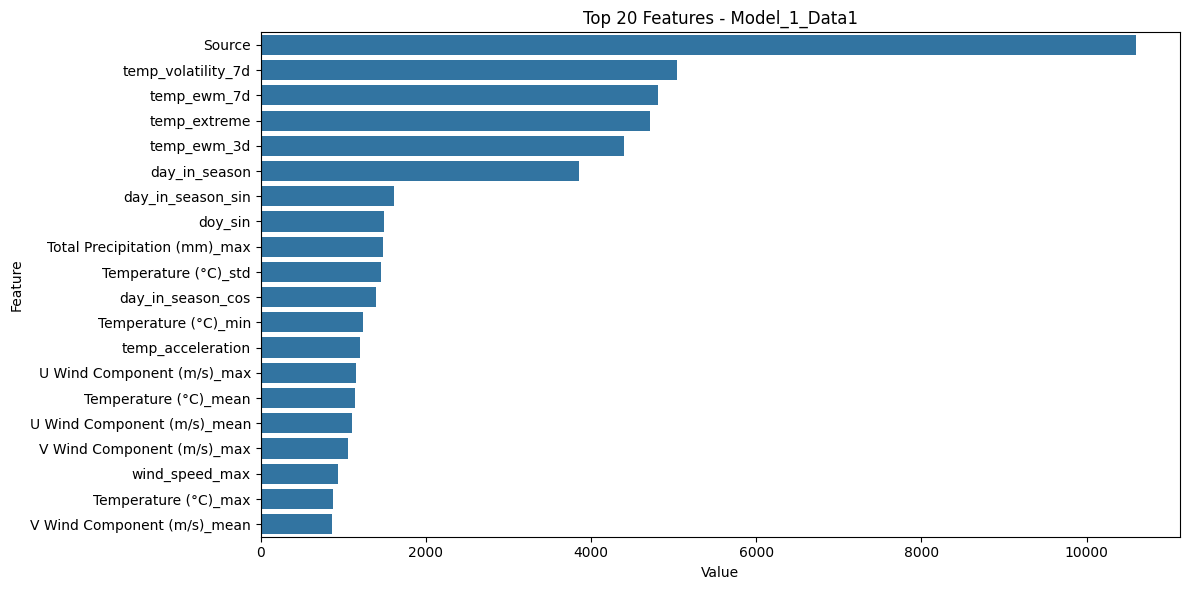

2025-04-22 12:47:15,139 - INFO - Fold 1 completed in 38.31 seconds
2025-04-22 12:47:15,139 - INFO - =====================
2025-04-22 12:47:15,139 - INFO - Fold 2/5 for Model_1_Data1
2025-04-22 12:47:15,139 - INFO - Train: 11986 samples, Validation: 2997 samples
2025-04-22 12:47:15,143 - INFO - y_train statistics: min=0.0000, max=110.8552, mean=3.3748
2025-04-22 12:47:15,143 - INFO - y_val statistics: min=0.0000, max=88.1238, mean=3.3569
2025-04-22 12:47:15,143 - INFO -   ---------------------
2025-04-22 12:47:15,157 - INFO -   Training base model 1/7 (precise)...
2025-04-22 12:47:15,157 - INFO -   Parameters: {
  "n_estimators": 2000,
  "learning_rate": 0.01,
  "max_depth": 8,
  "num_leaves": 31,
  "colsample_bytree": 0.8,
  "subsample": 0.8,
  "reg_alpha": 0.1,
  "reg_lambda": 0.1,
  "min_child_weight": 10,
  "random_state": 42,
  "objective": "rmse",
  "metric": "rmse",
  "verbose": -1,
  "early_stopping_rounds": 100
}
2025-04-22 12:47:15,157 - INFO -   Starting training...
2025-04-2

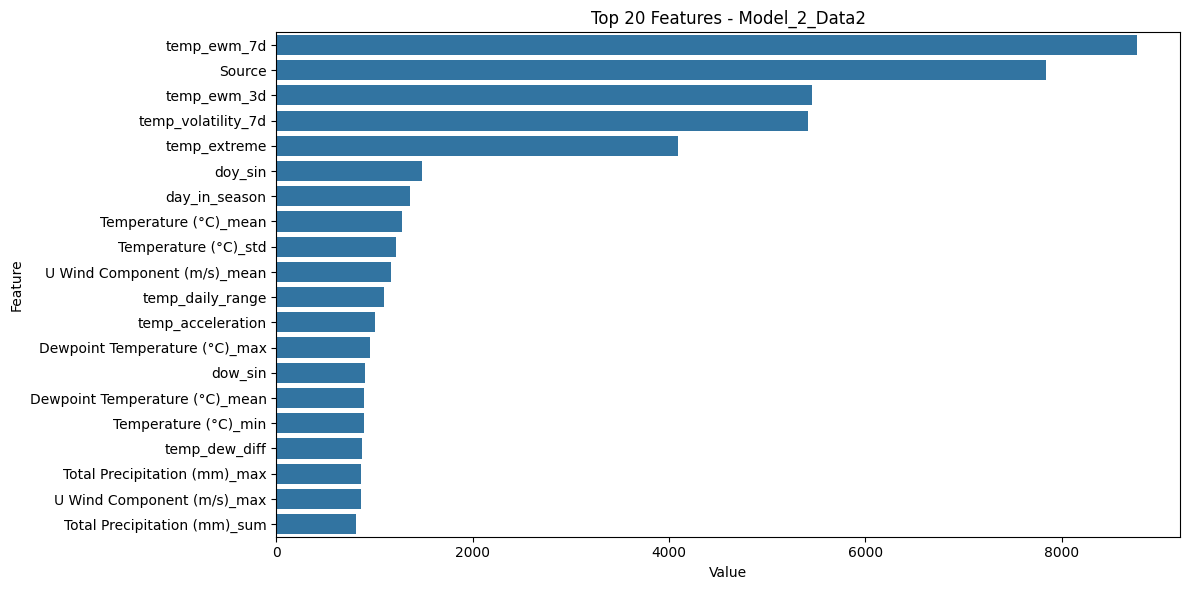

2025-04-22 12:49:55,959 - INFO - Fold 1 completed in 29.25 seconds
2025-04-22 12:49:55,959 - INFO - =====================
2025-04-22 12:49:55,959 - INFO - Fold 2/5 for Model_2_Data2
2025-04-22 12:49:55,959 - INFO - Train: 9050 samples, Validation: 2263 samples
2025-04-22 12:49:55,975 - INFO - y_train statistics: min=0.0000, max=122.5230, mean=2.0408
2025-04-22 12:49:55,975 - INFO - y_val statistics: min=0.0000, max=77.5092, mean=2.1173
2025-04-22 12:49:55,975 - INFO -   ---------------------
2025-04-22 12:49:55,975 - INFO -   Training base model 1/7 (precise)...
2025-04-22 12:49:55,975 - INFO -   Parameters: {
  "n_estimators": 2000,
  "learning_rate": 0.01,
  "max_depth": 8,
  "num_leaves": 31,
  "colsample_bytree": 0.8,
  "subsample": 0.8,
  "reg_alpha": 0.1,
  "reg_lambda": 0.1,
  "min_child_weight": 10,
  "random_state": 42,
  "objective": "rmse",
  "metric": "rmse",
  "verbose": -1,
  "early_stopping_rounds": 100
}
2025-04-22 12:49:55,986 - INFO -   Starting training...
2025-04-22

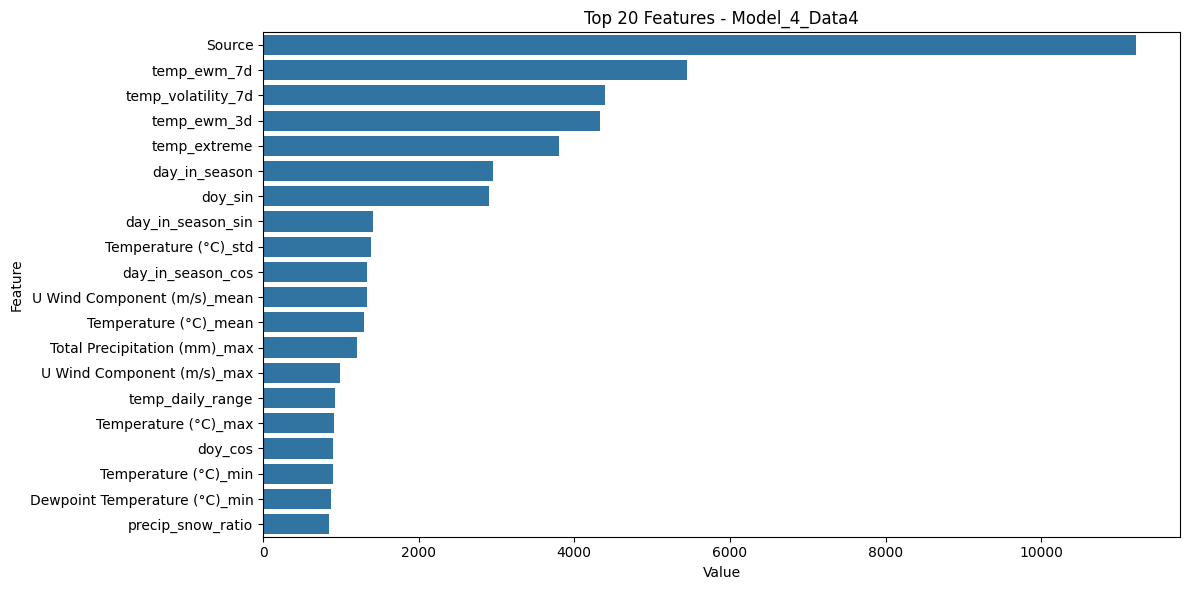

2025-04-22 12:52:24,498 - INFO - Fold 1 completed in 36.20 seconds
2025-04-22 12:52:24,498 - INFO - =====================
2025-04-22 12:52:24,498 - INFO - Fold 2/5 for Model_4_Data4
2025-04-22 12:52:24,498 - INFO - Train: 21038 samples, Validation: 5260 samples
2025-04-22 12:52:24,512 - INFO - y_train statistics: min=0.0000, max=122.5230, mean=2.8067
2025-04-22 12:52:24,514 - INFO - y_val statistics: min=0.0000, max=104.8954, mean=2.7993
2025-04-22 12:52:24,515 - INFO -   ---------------------
2025-04-22 12:52:24,516 - INFO -   Training base model 1/7 (precise)...
2025-04-22 12:52:24,518 - INFO -   Parameters: {
  "n_estimators": 2000,
  "learning_rate": 0.01,
  "max_depth": 8,
  "num_leaves": 31,
  "colsample_bytree": 0.8,
  "subsample": 0.8,
  "reg_alpha": 0.1,
  "reg_lambda": 0.1,
  "min_child_weight": 10,
  "random_state": 42,
  "objective": "rmse",
  "metric": "rmse",
  "verbose": -1,
  "early_stopping_rounds": 100
}
2025-04-22 12:52:24,519 - INFO -   Starting training...
2025-04-

,Model,Mean CV RMSE,Std CV RMSE,OOF RMSE
0,Model1 (Data1),3.203590,0.287822,3.216452
1,Model2 (Data2),2.913767,0.117350,2.916138
2,Model4 (Complete),3.109440,0.340367,3.128014


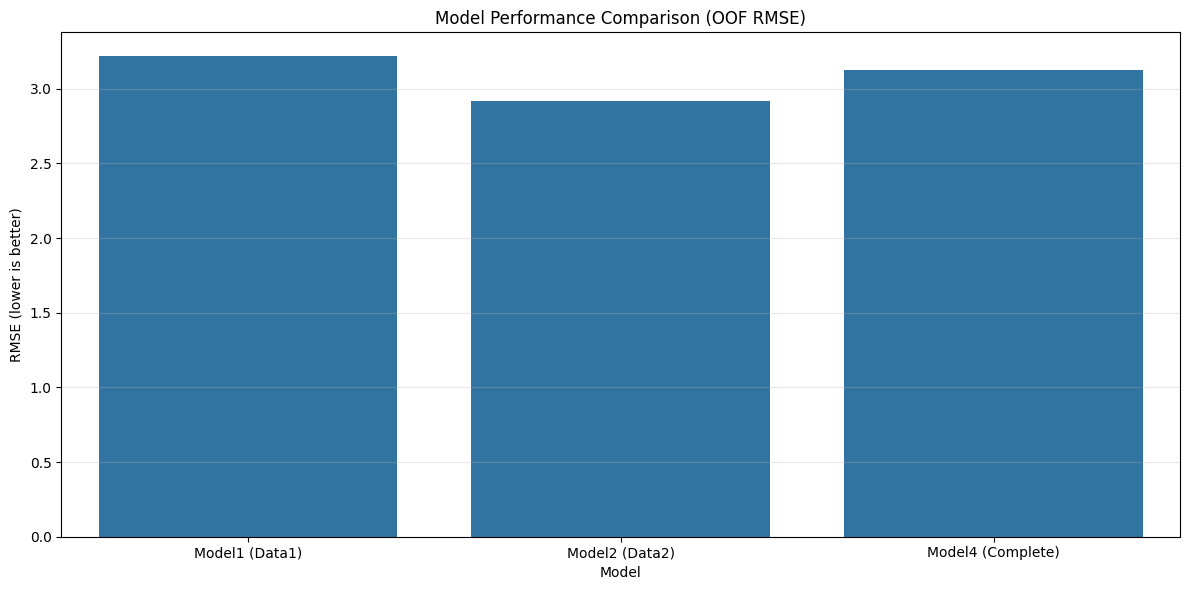

In [12]:
###########################################
# MODEL TRAINING
###########################################

# Model 1 - Data1 (late summer/early fall)
logger.info("Training Model 1 (Data1) => 5 folds")
models1, cols1, cv_scores1, oof_preds1, oof_rmse1 = train_model_cv(complete_data_1, "Model_1_Data1", n_folds=5)

# Model 2 - Data2 (winter/mid-summer)
logger.info("Training Model 2 (Data2) => 5 folds")
models2, cols2, cv_scores2, oof_preds2, oof_rmse2 = train_model_cv(complete_data_2, "Model_2_Data2", n_folds=5)

# Model 3 - Data3 (other periods) - NO CV
logger.info("Training Model 3 (Data3) => NO CV")
models3, cols3 = train_model_no_cv(complete_data_3, "Model_3_Data3")

# Model 4 - Complete dataset
logger.info("Training Model 4 (Complete Data) => 5 folds")
models4, cols4, cv_scores4, oof_preds4, oof_rmse4 = train_model_cv(complete_data_4, "Model_4_Data4", n_folds=5)

# Display model performance comparison
model_perf = pd.DataFrame({
    'Model': ['Model1 (Data1)', 'Model2 (Data2)', 'Model4 (Complete)'],
    'Mean CV RMSE': [np.mean(cv_scores1), np.mean(cv_scores2), np.mean(cv_scores4)],
    'Std CV RMSE': [np.std(cv_scores1), np.std(cv_scores2), np.std(cv_scores4)],
    'OOF RMSE': [oof_rmse1, oof_rmse2, oof_rmse4]
})
display(model_perf)

# Plot CV scores comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='OOF RMSE', data=model_perf)
plt.title('Model Performance Comparison (OOF RMSE)')
plt.ylabel('RMSE (lower is better)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Test Preparation and Predictions

This section:
1. Prepares the test data by applying the same feature engineering pipeline
2. Generates predictions using each of the four models
3. Creates the final ensemble prediction with a sophisticated weighting scheme
4. Ensures all predictions are non-negative

2025-04-22 13:55:40,053 - INFO - Preparing test data (SampleSubmission) + advanced features...
2025-04-22 13:55:40,110 - INFO - Adding advanced features...
2025-04-22 13:55:41,274 - INFO - Making predictions with all models...
2025-04-22 13:55:41,280 - INFO - Predictions for Model 1 (CV)...
2025-04-22 13:55:41,281 - INFO - Starting prediction with 5 models on 6014 samples...
2025-04-22 13:55:41,290 - INFO - Using 56/56 available columns for prediction
2025-04-22 13:55:41,294 - INFO - Detection of stacked models with optimal weights...
2025-04-22 13:55:41,295 - INFO -   Prediction for fold 1/5...
2025-04-22 13:55:41,297 - INFO -     Prediction with base model 1/7...
2025-04-22 13:55:41,571 - INFO -     Prediction statistics for model 1: min=-8.7989, max=88.9261, mean=3.8182
2025-04-22 13:55:41,572 - INFO -     Prediction with base model 2/7...
2025-04-22 13:55:41,712 - INFO -     Prediction statistics for model 2: min=-7.0762, max=88.6284, mean=3.7024
2025-04-22 13:55:41,714 - INFO -   

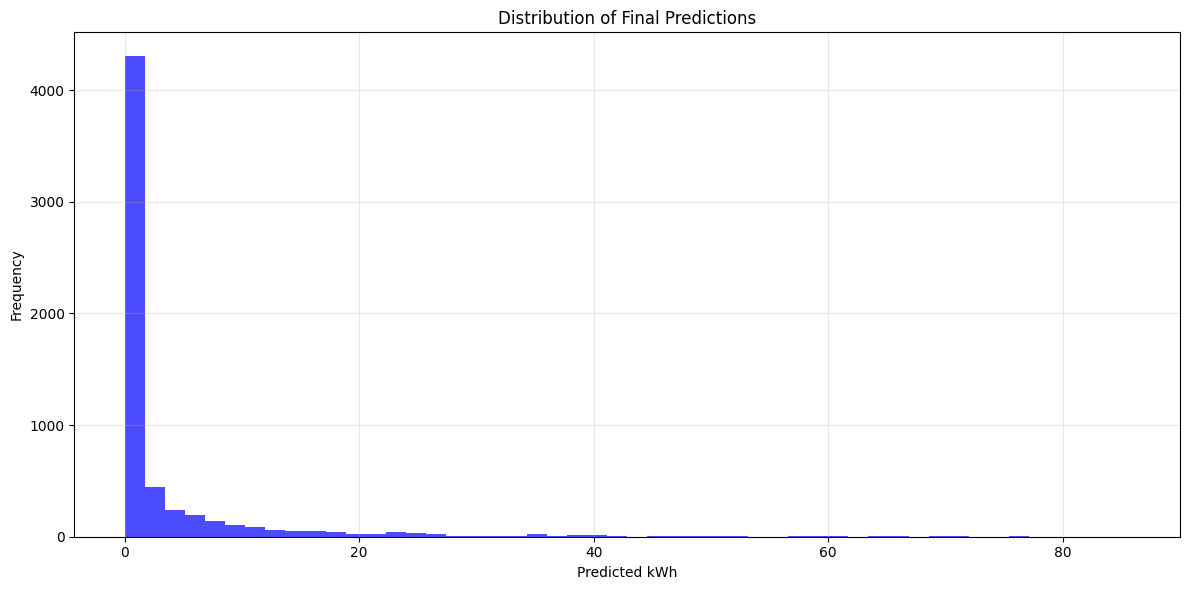

In [ ]:
###########################################
# TEST PREPARATION
###########################################
logger.info("Preparing test data (SampleSubmission) + advanced features...")

# Reload sample submission to ensure we have a clean copy
ss = pd.read_csv("datasets/SampleSubmission.csv")

# Copy sample submission for predictions
forecast = ss.copy()

# Extract date and source information
forecast['Date'] = pd.to_datetime(forecast['ID'].str.extract(r'(\d{4}-\d{2}-\d{2})')[0])
forecast[['DateSplit','device','data','user']] = forecast['ID'].str.split('_',expand=True,n=3)
forecast['Source'] = forecast['device'] + '_' + forecast['data'] + '_' + forecast['user']
forecast.drop(columns=['device','data','user','DateSplit'], inplace=True, errors='ignore')

# Apply advanced feature engineering to test data
forecast = add_advanced_features(forecast, climate_df)

# Prepare test data for prediction
X_test = forecast.drop(columns=['Date','kwh','ID'], errors='ignore')


logger.info("Making predictions with all models...")

logger.info("Predictions for Model 1 (CV)...")
preds_1 = predict_with_cv_models(models1, X_test, cols1)

logger.info("Predictions for Model 2 (CV)...")
preds_2 = predict_with_cv_models(models2, X_test, cols2)

logger.info("Predictions for Model 3 (direct training)...")
preds_3 = predict_with_cv_models(models3, X_test, cols3)

logger.info("Predictions for Model 4 (CV)...")
preds_4 = predict_with_cv_models(models4, X_test, cols4)

# Create multi-level ensemble with optimized weights
w1, w2, w3, w4 = 0.85, 0.025, 0.025, 0.1  # Weights adjusted according to data segmentation, w1 is high is because data1 to close to the testing period
logger.info(f"Creating final ensemble with weights: {w1}, {w2}, {w3}, {w4}")

# Multi-level ensemble formula
final_preds = 0.3*preds_1 + 0.65*(0.7*preds_1 + 0.2*(0.8*preds_1 + 0.1*(w1*preds_1 + w2*preds_2 + w3*preds_3 + w4*preds_4) + 0.1*preds_4) + 0.1*preds_4) + 0.05*preds_4

# Ensure all predictions are non-negative
final_preds = np.maximum(0, final_preds)

# Create submission file
submission = ss.copy()
submission['kwh'] = final_preds
submission.to_csv('output/final_submission.csv', index=False)
logger.info(f"✅ Submission file generated with ensemble weights: {w1}, {w2}, {w3}, {w4}")

# Plot distribution of final predictions
plt.figure(figsize=(12, 6))
plt.hist(final_preds, bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Final Predictions')
plt.xlabel('Predicted kWh')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

2025-04-22 13:56:18,296 - INFO - Generating visualization of predictions...


,Model,Min,Max,Mean,Median,Std Dev
0,Model1(Data1),-8.338097,86.925886,3.554987,0.484840,8.910422
1,Model2(Data2),-1.459466,28.204362,1.448092,0.207830,3.406915
2,Model3(Data3),0.000612,0.000612,0.000612,0.000612,0.000000
3,Model4(Data4),-2.021524,78.061714,2.773421,0.116442,6.918364
4,"Ensemble(0.85,0.025,0.025,0.1)",0.000000,85.725768,3.511603,0.439448,8.571649


2025-04-22 13:56:19,186 - INFO - ✅ Histograms saved to output/histograms_advanced_models.png
2025-04-22 13:56:19,186 - INFO - Plotting temporal evolution...
2025-04-22 13:56:19,436 - INFO - ✅ Temporal evolution saved to output/timeline_predictions_advanced.png
2025-04-22 13:56:19,437 - INFO - ✅ Analysis and visualizations complete


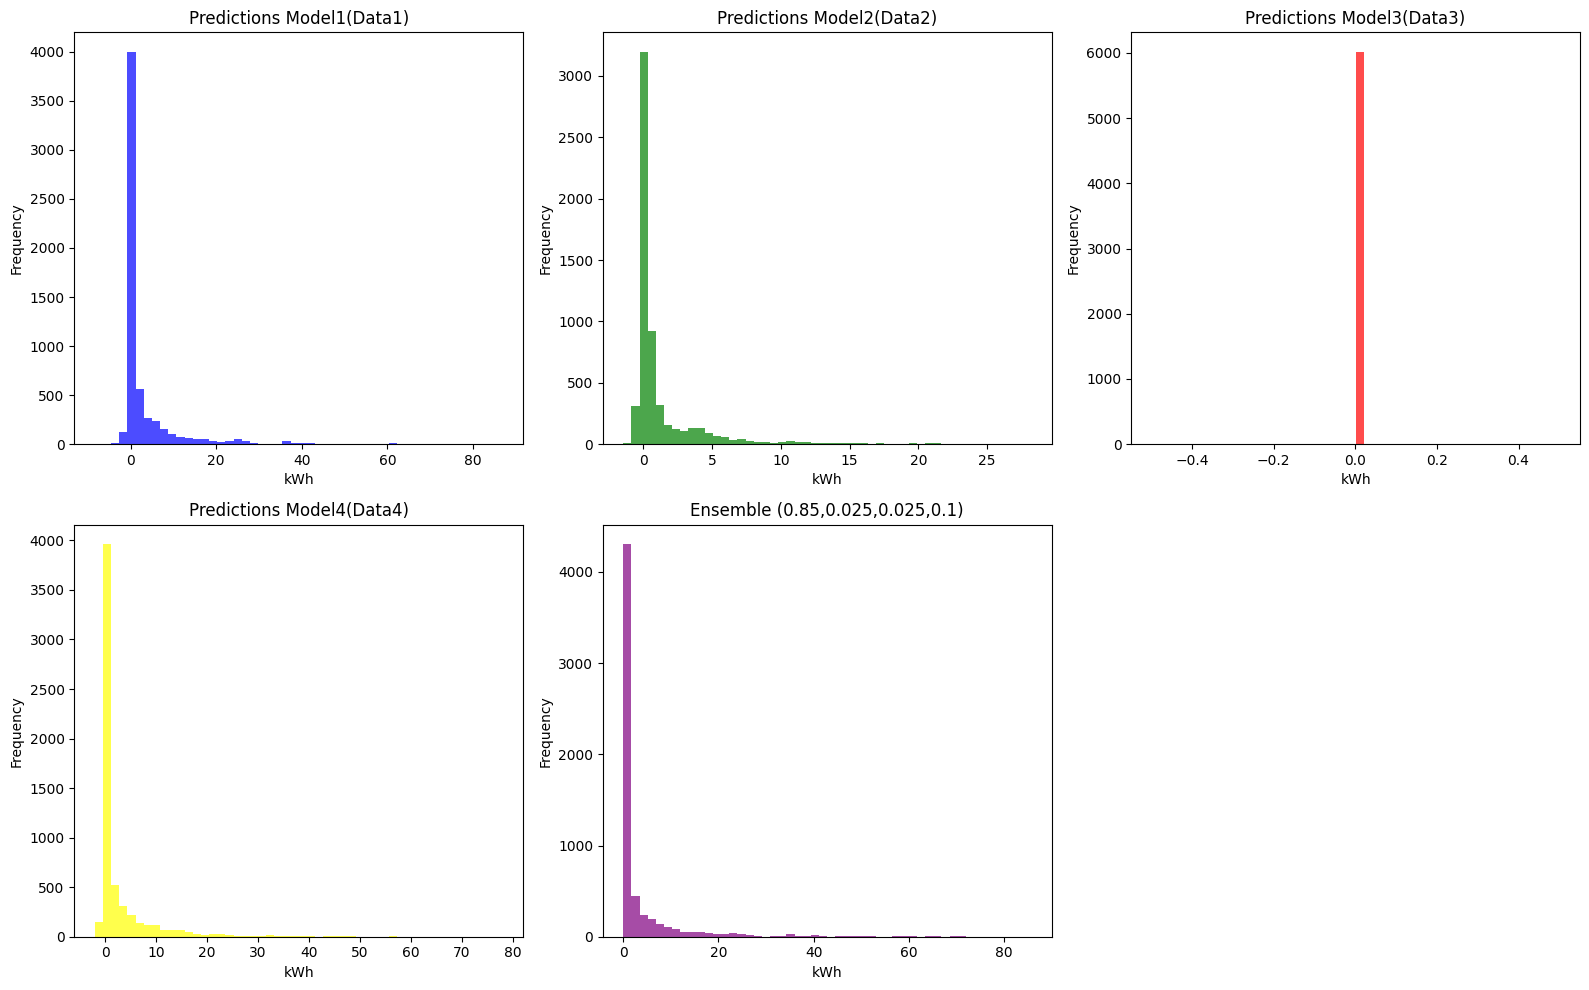

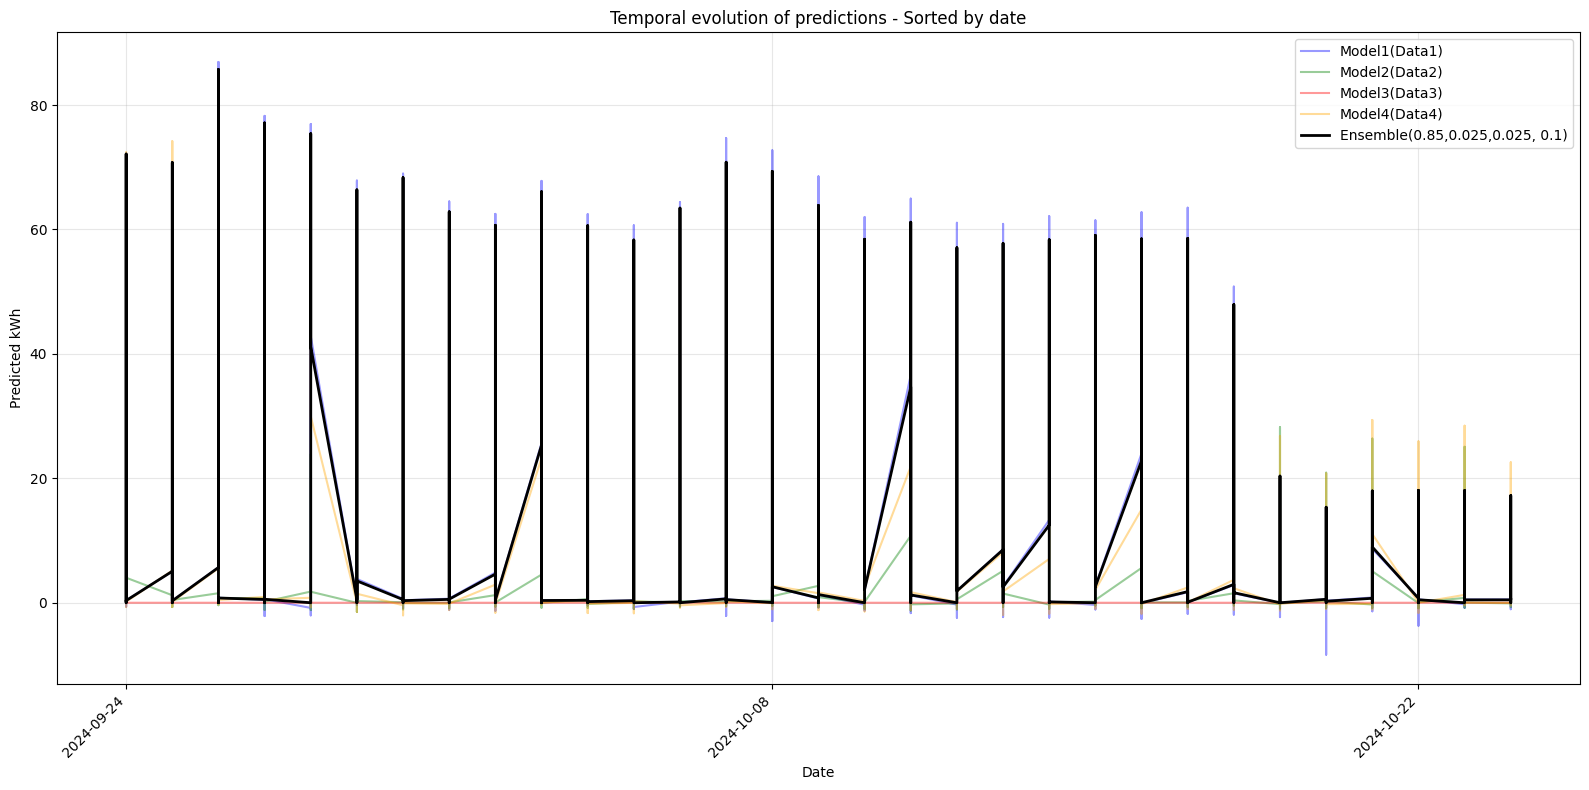

In [14]:
###########################################
# 13. VISUALIZATIONS AND ANALYSES
###########################################
logger.info("Generating visualization of predictions...")

# 1) PREDICTION STATISTICS
stats_data = {
    'Model': ['Model1(Data1)', 'Model2(Data2)', 'Model3(Data3)', 'Model4(Data4)', f'Ensemble({w1},{w2},{w3},{w4})'],
    'Min': [preds_1.min(), preds_2.min(), preds_3.min(), preds_4.min(), final_preds.min()],
    'Max': [preds_1.max(), preds_2.max(), preds_3.max(), preds_4.max(), final_preds.max()],
    'Mean': [preds_1.mean(), preds_2.mean(), preds_3.mean(), preds_4.mean(), final_preds.mean()],
    'Median': [np.median(preds_1), np.median(preds_2), np.median(preds_3), np.median(preds_4), np.median(final_preds)],
    'Std Dev': [preds_1.std(), preds_2.std(), preds_3.std(), preds_4.std(), final_preds.std()],
}
stats_df = pd.DataFrame(stats_data)
display(stats_df)
stats_df.to_csv('output/predictions_stats_advanced.csv', index=False)

# 2) HISTOGRAMS
plt.figure(figsize=(16, 10))
plt.subplot(2, 3, 1)
plt.hist(preds_1, bins=50, alpha=0.7, color='blue')
plt.title("Predictions Model1(Data1)")
plt.xlabel("kWh")
plt.ylabel("Frequency")

plt.subplot(2, 3, 2)
plt.hist(preds_2, bins=50, alpha=0.7, color='green')
plt.title("Predictions Model2(Data2)")
plt.xlabel("kWh")
plt.ylabel("Frequency")

plt.subplot(2, 3, 3)
plt.hist(preds_3, bins=50, alpha=0.7, color='red')
plt.title("Predictions Model3(Data3)")
plt.xlabel("kWh")
plt.ylabel("Frequency")

plt.subplot(2, 3, 4)
plt.hist(preds_4, bins=50, alpha=0.7, color='yellow')
plt.title("Predictions Model4(Data4)")
plt.xlabel("kWh")
plt.ylabel("Frequency")

plt.subplot(2, 3, 5)
plt.hist(final_preds, bins=50, alpha=0.7, color='purple')
plt.title(f"Ensemble ({w1},{w2},{w3},{w4})")
plt.xlabel("kWh")
plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig("output/histograms_advanced_models.png")
logger.info("✅ Histograms saved to output/histograms_advanced_models.png")

# 3) TEMPORAL EVOLUTION
logger.info("Plotting temporal evolution...")
dates = forecast['Date']
sorted_idx = np.argsort(dates)
sorted_dates = dates.iloc[sorted_idx]

sorted_1 = preds_1[sorted_idx]
sorted_2 = preds_2[sorted_idx]
sorted_3 = preds_3[sorted_idx]
sorted_4 = preds_4[sorted_idx]
sorted_final = final_preds[sorted_idx]

plt.figure(figsize=(16, 8))
plt.plot(sorted_dates, sorted_1, 'b-', label='Model1(Data1)', alpha=0.4)
plt.plot(sorted_dates, sorted_2, 'g-', label='Model2(Data2)', alpha=0.4)
plt.plot(sorted_dates, sorted_3, 'r-', label='Model3(Data3)', alpha=0.4)
plt.plot(sorted_dates, sorted_4, 'orange', label='Model4(Data4)', alpha=0.4)
plt.plot(sorted_dates, sorted_final, 'k-', label=f'Ensemble({w1},{w2},{w3}, {w4})', linewidth=2)
plt.title("Temporal evolution of predictions - Sorted by date")
plt.xlabel("Date")
plt.ylabel("Predicted kWh")
plt.legend()
plt.grid(True, alpha=0.3)

import matplotlib.dates as mdates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig("output/timeline_predictions_advanced.png")
logger.info("✅ Temporal evolution saved to output/timeline_predictions_advanced.png")

logger.info("✅ Analysis and visualizations complete")


## Conclusion and Performance Summary

This solution demonstrates how **strategic data segmentation** and **advanced ensemble methods** can yield outstanding energy-consumption predictions even under challenging climatic conditions.

### Key Performance Metrics
- **Private Leaderboard RMSE**: `4.312706649`
- **Final Rank**: `1st Place`

### Strengths of the Approach
1. **Targeted Data Segmentation**  
   By partitioning the data according to seasonal consumption patterns, each model learned the behaviors most relevant to its assigned date range.
2. **Tailored Feature Engineering**  
   Custom features reflecting Pakistan’s unique climate and cultural variables helped capture crucial consumption drivers.
3. **Ensemble Diversity**  
   Multiple LightGBM models with diverse hyperparameters minimized overfitting and enriched the final blended predictions.
4. **Bayesian Optimization**  
   Automatically finding the optimal ensemble weights provided additional performance gain by ensuring the most effective model blend.

### Future Directions
1. **Device-Specific Modeling**  
   Training specialized models for different device types or user profiles may further boost accuracy.
2. **Time-Series Integration & Expanded Modeling**  
   Leveraging additional forecasting approaches—like ARIMA or other specialized time-series frameworks, advanced gradient boosting variants, or deeper feature engineering and feature selection—could uncover more nuanced temporal patterns.
3. **Zero-Consumption Handling**  
   Investigating more nuanced approaches for prolonged zero-usage segments might clarify low-demand periods.
4. **Extreme Weather Modeling**  
   Dedicated routines for severe temperature or weather shocks could further strengthen predictive robustness.

This winning solution highlights the power of **domain-informed feature engineering** and **methodical ensembling**, delivering robust, high-accuracy predictions for real-world energy consumption scenarios.
